# IMA204 Practical Session - Segmentation of medical images



# Introduction

Images to use are provided in a zip file called **data.zip** to install in your local directory from where you are running this notebook.

The goal of this practical session is to push K-means segmentation method as a pre-segmentation tool on different types of medical images: CT scans for the segmentation of kidneys and tumors, MRI for the corpus callosum in the brain , temporal sequences of MRI images for segmentation of the myocardium.

You are provided with pre-processing ideas. 
You will have to adjust a pipeline for **AT LEAST** one application (kidney/tumor, corpus callosum or heart).

You have to submit your code and comment your results. 

**Deadline**: You will have to upload a single jupyter notebook .ipynb with your answers (code + text) before the deadline (please check on Ecampus/Moodle). 

**The uploaded file should be named 'TP_SegMedImage_YOURSURNAME.ipynb'.** 

**RUN THE WHOLE NOTEBOOK FIRST TO GET A FULL OVERVIEW OF USE-CASES AND THE NOTION OF HYPERPARAMETERS.**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# For ploting utilities of contours on images
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For listing files in local foler
import glob

# For loading .mat files
from scipy.io import loadmat

import skimage
from skimage.io import imread
from skimage import morphology
from skimage.segmentation import watershed 
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage.morphology import disk
from scipy import ndimage
from skimage.measure import find_contours
import skimage.morphology as morpho  
from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation
from skimage.filters import gaussian


# For Kmeans
import cv2 


Working_directory = os.getcwd()
print('Working_directory = ',Working_directory)


Working_directory =  E:\E_Code\IMA204\TP4_segmentation_medical_image


In [2]:
def my_kmeans(image,k):
    #k = number of clusters
    
    # Reshaping the image  
    pixel_vals = image.reshape((-1,1)) 

    # Convert to float type only for supporting cv2.kmean
    pixel_vals = np.float32(pixel_vals)
    criteria   = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) #criteria
    retval, labels, centers = cv2.kmeans(pixel_vals, k, 
                None, criteria, 10, cv2.KMEANS_PP_CENTERS) 
    centers = np.uint8(centers) # convert data into 8-bit values 
    
    segmented_data   = centers[labels.flatten()] # Mapping labels to center points( RGB Value)
    segmented_image  = segmented_data.reshape((image.shape)) # reshape data into the original image dimensions

    segmented_labels = labels # Mapping labels to center points( RGB Value)
    segmented_labels = segmented_labels.reshape((image.shape)) # reshape data into the original image dimensions
    
    return segmented_image,segmented_labels


def my_colormap_white_bkg(Colormap_name,numLabels):
    #numLabels = number of colors
    
    Colormap  = plt.get_cmap(Colormap_name, numLabels)
    newcolors = Colormap(np.linspace(0, 1, numLabels))
    bkg_color = np.array([256/256, 256/256, 256/256, 1])
    max_color = np.array([0/256, 0/256, 0/256, 1])
    newcolors[numLabels-1, :] = max_color
    newcolors[0, :] = bkg_color
    newcmp = ListedColormap(newcolors)
    return newcmp

## Abdominal CT 

You have at your disposal **6 abdominal CT scans** of different subjects. Subjects may have renal tumor. You also have the manual segmentations for both kidney and, when present, the tumor. 

Variables defined: <br>
* abdominalCT_path
* listImagesabdCT
* Img_abdo_ex
* Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

There are 6 abdomical CT images
Reading image  E:\E_Code\IMA204\TP4_segmentation_medical_image/data/abdominalCT\CTs1.tiff
[  0 127 255]


Text(0.5, 1.0, 'Image +contour tumor')

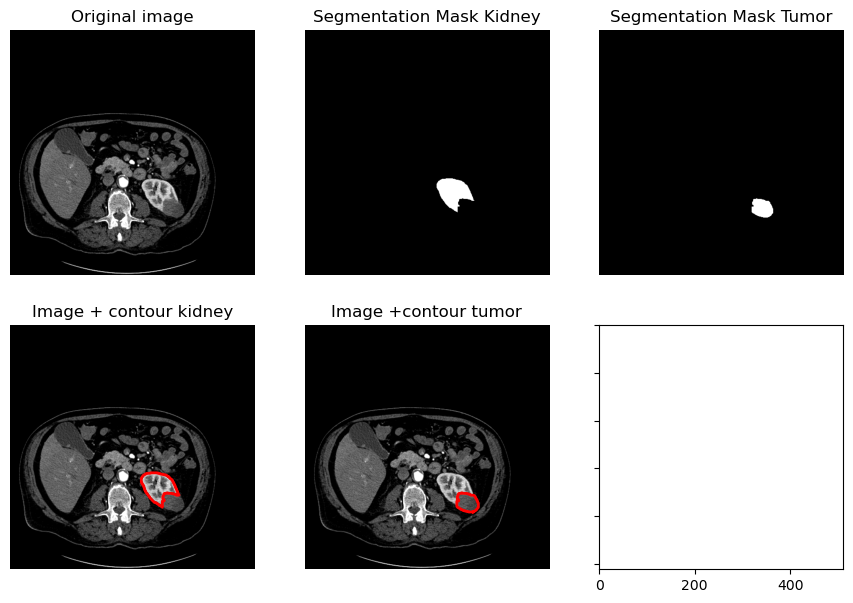

In [3]:
abdominalCT_path = Working_directory + '/data/abdominalCT'  
os.listdir(abdominalCT_path)
listImagesabdCT=glob.glob(abdominalCT_path + '/*-seg.tiff')
print('There are', len(listImagesabdCT),  'abdomical CT images')

# Choose a figure and plot it with the ground truth segmentation
indexIm=0 # between 0 and 5

# Abdominal CT
filename_Segmentation = listImagesabdCT[indexIm]
Labels_abdo_ex   = imread(filename_Segmentation)
filename         = filename_Segmentation[:-9] + '.tiff'
Img_abdo_ex      = imread(filename) 

print('Reading image ', filename)
print(np.unique(Labels_abdo_ex))

if Img_abdo_ex.shape != Labels_abdo_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Labels_abdo_ex we may have two values: 127 is for kidney and 255 for renal tumor
Seg_abdo_kidney_ex=Labels_abdo_ex==127
if np.sum(Seg_abdo_kidney_ex)==0:
  print('There is no kidney')
Cont_abdo_kidney_ex = find_contours(Seg_abdo_kidney_ex, 0.5)

Seg_abdo_tumor_ex=Labels_abdo_ex==255
if np.sum(Seg_abdo_tumor_ex)==0:
  print('There is no tumor')
Cont_abdo_tumor_ex = find_contours(Seg_abdo_tumor_ex, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_abdo_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(Seg_abdo_kidney_ex,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask Kidney")
grid[2].imshow(Seg_abdo_tumor_ex,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Segmentation Mask Tumor")
grid[3].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_kidney_ex:
  grid[3].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[3].axis('off')
grid[3].set_title("Image + contour kidney")
grid[4].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_tumor_ex:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[4].axis('off')
grid[4].set_title("Image +contour tumor")


# Brain MRI

Here you can select medial slices of the brain of **4 different subjects**. You also have manual segmentations of the corpus callosum.

Variables defined: <br>
* brainMRI_path
* listImagesbrainMRI
* Seg_brain_ex
* Img_brain_ex

There are 4 brain MRI images
['E:\\E_Code\\IMA204\\TP4_segmentation_medical_image/data/brainMRI\\MRIs1-seg.png', 'E:\\E_Code\\IMA204\\TP4_segmentation_medical_image/data/brainMRI\\MRIs2-seg.png', 'E:\\E_Code\\IMA204\\TP4_segmentation_medical_image/data/brainMRI\\MRIs3-seg.png', 'E:\\E_Code\\IMA204\\TP4_segmentation_medical_image/data/brainMRI\\MRIs4-seg.png']
Reading image  E:\E_Code\IMA204\TP4_segmentation_medical_image/data/brainMRI\MRIs4.png


Text(0.5, 1.0, 'Image with segmentation\n corpus callosum')

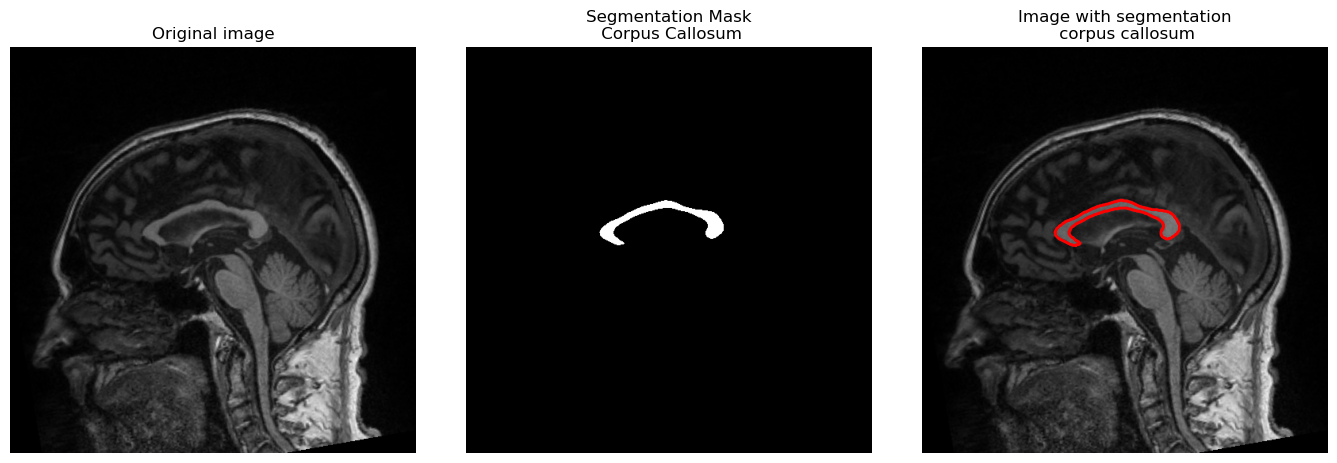

In [156]:
brainMRI_path = Working_directory + '/data/brainMRI'
os.listdir(brainMRI_path)
listImagesbrainMRI=glob.glob(brainMRI_path + '/*-seg.png')
print('There are', len(listImagesbrainMRI),  'brain MRI images')
print(listImagesbrainMRI)

# Choose a brain MRI and plot it with the ground truth segmentation
indexIm      = 3 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename) 

print('Reading image ', filename)

if Img_brain_ex.shape != Seg_brain_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Im Seg we have masks of the corpus callosum
maskCC      = Seg_brain_ex==255
contourMask = find_contours(maskCC, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_brain_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(maskCC,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask\n Corpus Callosum");
grid[2].imshow(Img_brain_ex, cmap='gray')
for contour in contourMask:
  grid[2].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[2].axis('off')
grid[2].set_title("Image with segmentation\n corpus callosum")


# Cardiac MRI 

The last section is about MRI sequences of the heart. 
You are provided with **a single use case**. 
Your goal is to segment the left ventricule. Be careful, the segmentation is not a maks but a series of points (landmarks). To obtain a binary mask, you should first interpolate the points (using for instance a spline). <br> 

The structure of this image data is more complex and needs some coding to load single slices to segment.


Variables defined: <br>
* MRIheart_path
* Img_cardiac_ex
* Seg_cardiac_ex


MRI volume of the heart composed of 11 slices along the z axis and 20 temporal frames. Each slice is an image  256  x  256
For each slice and at each time frame we have a manual segmentation composed of 65 2D landmarks
Be careful, some slices do not contain the left ventricle myocardium and the manual segmentation is not simply empty but it contains the value: [[-99999]]


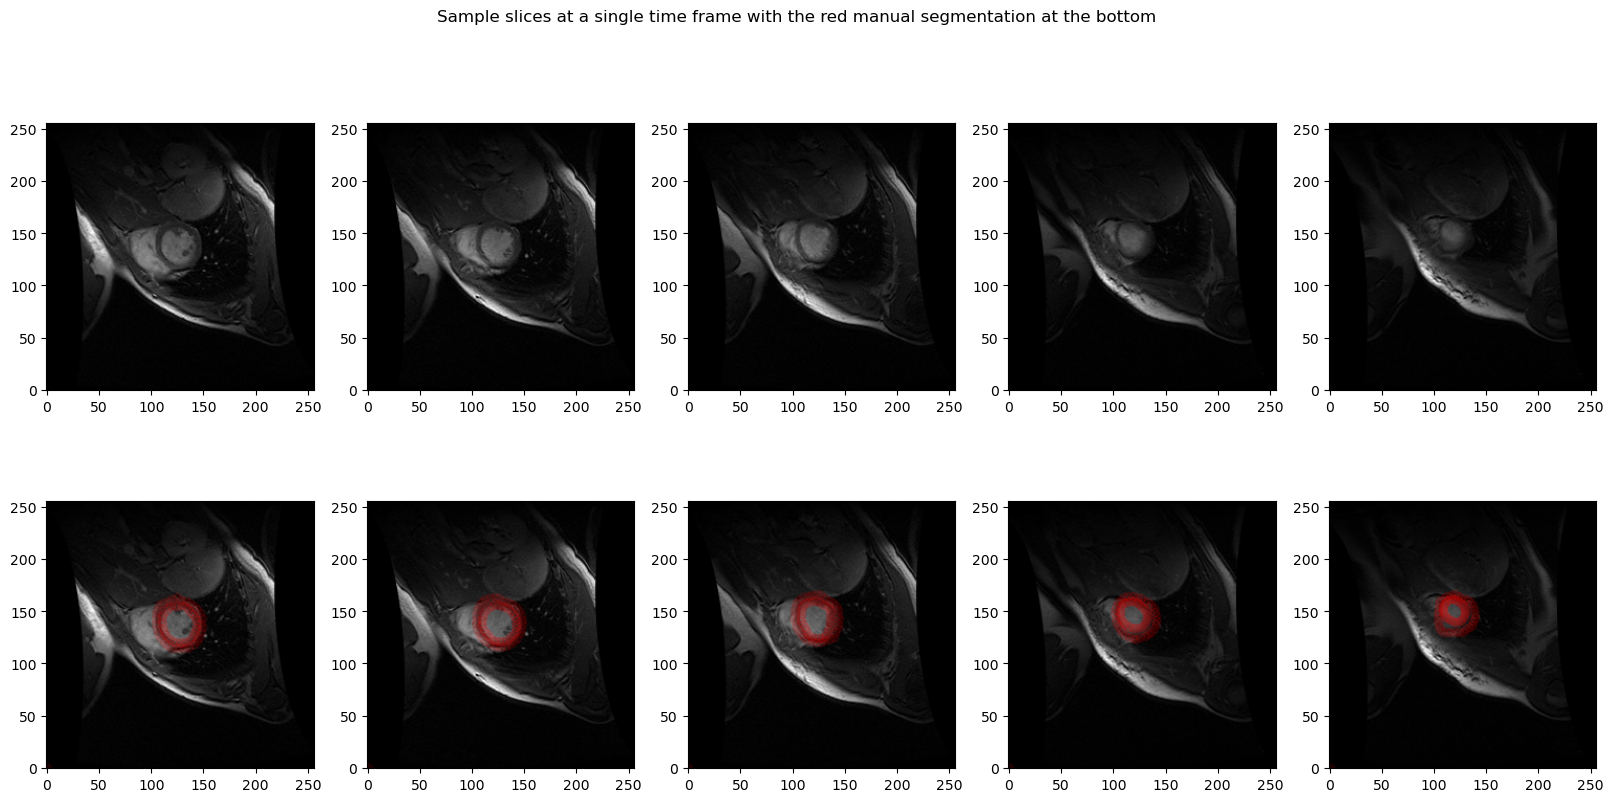

In [5]:

# Read one case
MRIheart_path = Working_directory + '/data/MRIheart/'
os.listdir(MRIheart_path)
data          = loadmat(MRIheart_path + 'dataMRIheart.mat')
data          = data['data']
seg           = loadmat(MRIheart_path + 'segMRIheart.mat')
seg           = seg['seg']

Ex_index_select = 6
Img_cardiac_ex = data[:,:,Ex_index_select,1] # can be index 4,5,6,...
Cont_cardiac_ex = seg[Ex_index_select,1][:]

print('MRI volume of the heart composed of', data.shape[2], 'slices along the z axis and', data.shape[3], 
'temporal frames. Each slice is an image ', data.shape[0], ' x ',  data.shape[1])
print('For each slice and at each time frame we have a manual segmentation composed of',seg[4,4].shape[0] , '2D landmarks')

print('Be careful, some slices do not contain the left ventricle myocardium and the manual segmentation is not simply empty but it contains the value:', seg[0,0] )

plt.figure(figsize=(20, 9))
plt.suptitle('Sample slices at a single time frame with the red manual segmentation at the bottom')
plt.subplot(2, 5, 1)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 2)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 3)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 4)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 5)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 6)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[4,1][:,0], seg[4,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 7)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[5,1][:,0], seg[5,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 8)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[6,1][:,0], seg[6,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 9)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[7,1][:,0], seg[7,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 10)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[8,1][:,0], seg[8,1][:,1], c='r',alpha=0.1); 

In [16]:
seg[6,1] # seg: array 11, 20, each element is 65,1 if there is the target thing

array([[114.18201073, 128.82917967],
       [112.87732889, 131.82360044],
       [111.50127588, 134.80173318],
       [109.54812939, 137.40295317],
       [108.3879552 , 140.35765916],
       [108.07676381, 143.61092143],
       [108.02228195, 146.87398421],
       [108.36144904, 150.12361425],
       [108.83917819, 153.35075481],
       [110.0954397 , 156.31201469],
       [112.66197491, 158.256809  ],
       [115.81427327, 159.06243701],
       [119.02370539, 159.62963671],
       [122.25829779, 159.51869777],
       [125.34005032, 158.43755996],
       [128.3671259 , 157.1768985 ],
       [131.33859777, 155.820026  ],
       [134.0711444 , 154.04933723],
       [135.81657225, 151.34325856],
       [136.23275048, 148.12576099],
       [135.96286509, 144.86897542],
       [135.98237753, 141.62315824],
       [135.68400632, 138.38577168],
       [135.02314325, 135.1801223 ],
       [133.82214831, 132.16602679],
       [132.26294921, 129.29572058],
       [130.73868935, 126.40972817],
 

## For cardiac MRI: how to create a binary mask from the provided contours

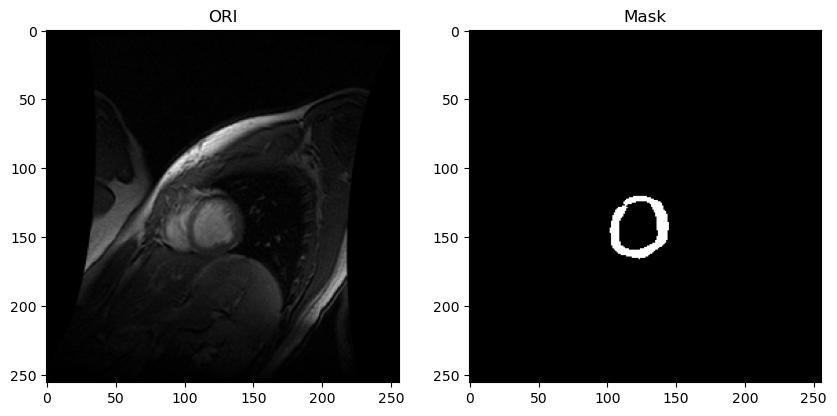

In [6]:
from skimage.draw import polygon

# Remove [0 0] point in provided contour
Cont_cardiac_ex = Cont_cardiac_ex[~np.all(Cont_cardiac_ex == 0, axis=1)]

Seg_cardiac_ex   = np.zeros_like(Img_cardiac_ex, dtype='bool')
rr, cc = polygon(Cont_cardiac_ex[:, 1], Cont_cardiac_ex[:, 0], Img_cardiac_ex.shape)
Seg_cardiac_ex[rr, cc] = 1

fig, axes        = plt.subplots(1,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_cardiac_ex,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(Seg_cardiac_ex,cmap='gray')
ax[1].set_title("Mask")

plt.show()

# Preliminaries
## Mathematical Morphology

Incitations to use morphological operators seen during the previous lectures to segment the provided images. 


Think about the structural elements and the hyper-parameters ... We typically adapt their values to the image resolution and type of structures targeted in our segmentation (eg. brigth or dark).



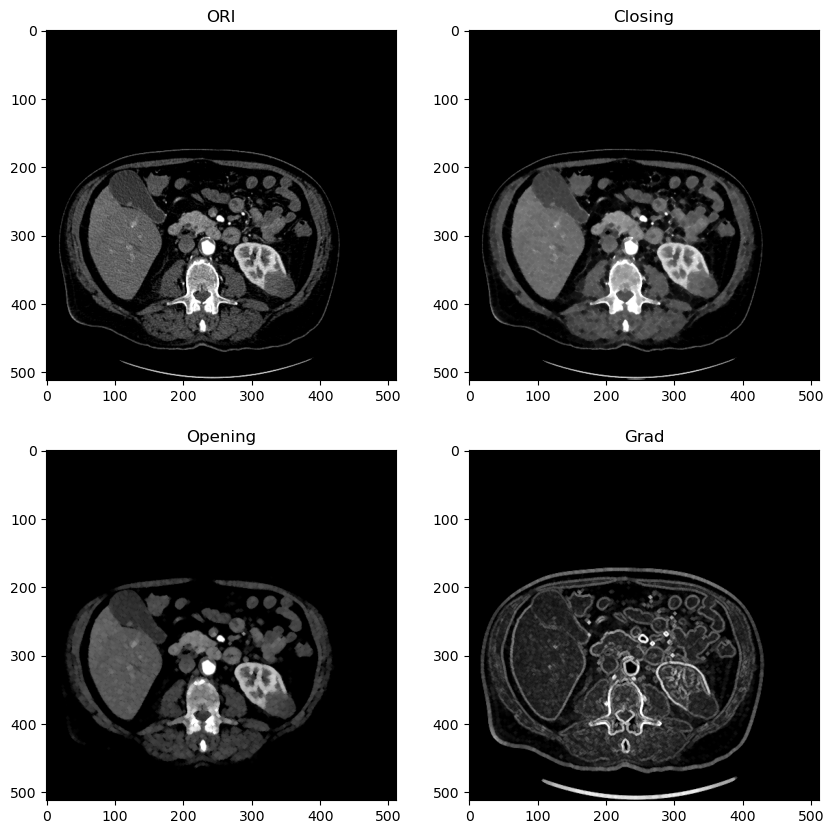

In [7]:
#Select input image
# Img_test         = Img_cardiac_ex
# Img_test         = Img_brain_ex
Img_test         = Img_abdo_ex ; # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

# Define Element
Radius           = 2
se               = disk(Radius)

# Morpho closing
Img_test_close  = morpho.closing(Img_test,se)

# Morpho Opening
Img_test_open    = morpho.opening(Img_test,se)

# Morpho Gradient
Img_test_grad  = morpho.dilation(Img_test,se)-morpho.erosion(Img_test,se)


#Figure display
fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')

ax[0].set_title("ORI")
ax[1].imshow(Img_test_close,cmap='gray')
ax[1].set_title("Closing")
ax[2].imshow(Img_test_open,cmap='gray')
ax[2].set_title("Opening")
ax[3].imshow(Img_test_grad,cmap='gray')
ax[3].set_title("Grad")

plt.show()

# Preliminaries
## Regular filtering

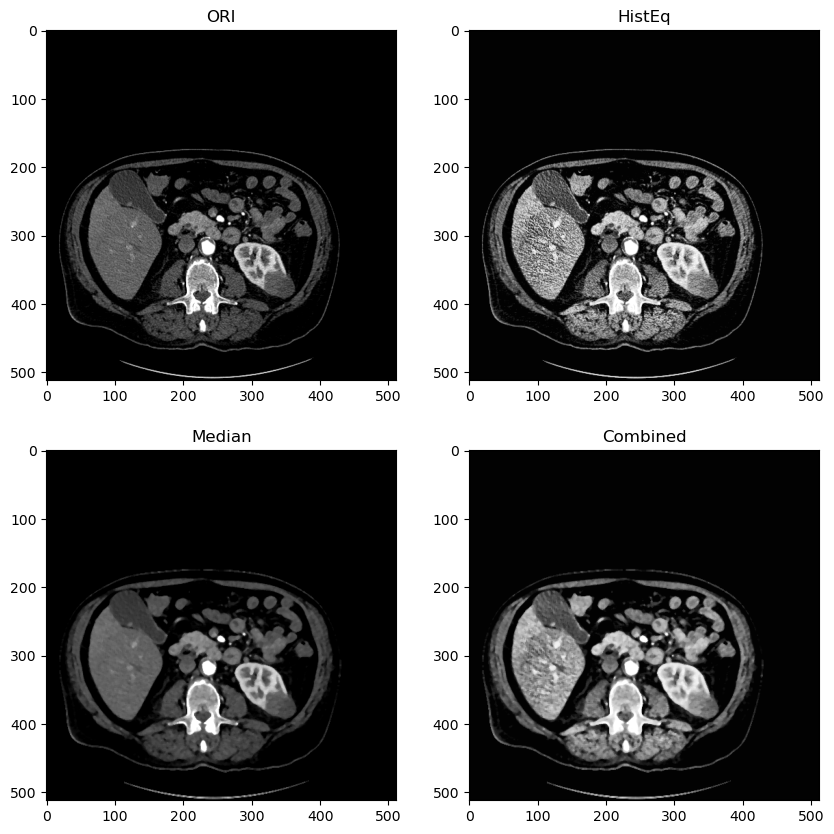

In [8]:

img_histeq    = skimage.exposure.equalize_adapthist(Img_test, clip_limit=0.03)
img_median    = ndimage.median_filter(Img_test, size=4)
img_histeqmed = ndimage.median_filter(img_histeq, size=4)

fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(img_histeq,cmap='gray')
ax[1].set_title("HistEq")
ax[2].imshow(img_median,cmap='gray')
ax[2].set_title("Median")
ax[3].imshow(img_histeqmed,cmap='gray')
ax[3].set_title("Combined");




# ASSIGNMENT:

**Question** 
Develop a segmentation pipeline building upon **kmeans** as proposed below for **at least one application** and report quality of segmentation results comparing your results to the provided ground truth on multiple images.

We want you to focus on **pre-processing** your image AND **post process** your segmentation result to extract **THE structure of interest**. For the postprocessing you can rely on extraction of connected components and apply to criteria (size, shape, position,..) to extract the composant that most likely corresponds to the structure of interest. 


When processing medical images, and given that you are provided with several ground-truth (gt) segmentations you can push the exercice to consider: <br>
* Cropping the field of view to remove the background (a common issue in medical images)
* Target a range of intensity values based on learning from the gt masks and corresponding images 
* Learn priors on shape/intensity statistics from the provided gt masks


## Kmeans routine to segment your images
Kmeans is very often used as pre-segmentation to initialise a finer segmentation.

Provides a segmentation of the image using k-means clustering.
Be careful: Kmeans uses random initialisation and is therefore different at each run and randomly assigns  labels to clusters (0,1,2,...,K).

 



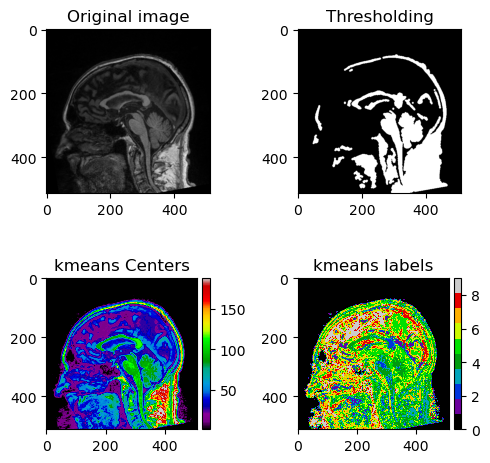

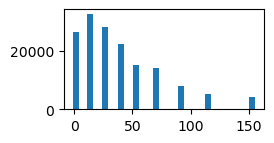

Your Target_value =  97
Distance of your Target_value to Centers =  [95 44 18 92  5 70 27 56 57 83]
Your selected label (starting with 0)=  4


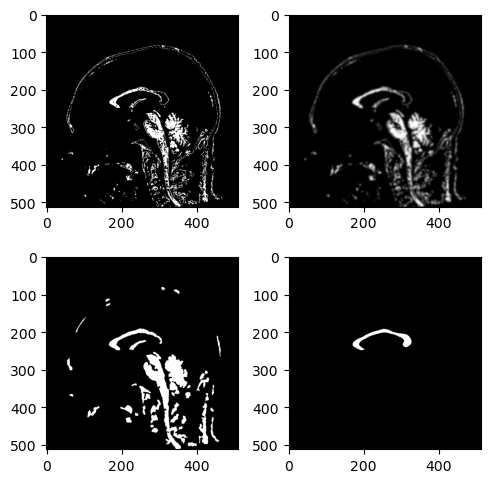

In [9]:
# Image use-case and HYPER-PARAMETER values provided as a good start

# Img_test         = Img_abdo_ex ; Img_seg_gt       = Seg_abdo_kidney_ex # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex
# nber_clusters    = 10; Target_value_thresh = 180 # For cardiac image
# Img_test            = Img_cardiac_ex; Img_seg_gt       = Seg_cardiac_ex
# nber_clusters       = 10; Target_value_thresh = 150 # For abdo image
Img_test          = Img_brain_ex ; Img_seg_gt       = Seg_brain_ex
nber_clusters     = 10; Target_value_thresh = 50 # For brain image




# [1] Example of segmentation via simple threshold 
# Compute a mask thresholding above target value
Seg_thresh          = morphology.remove_small_holes(
                        morphology.remove_small_objects(
                          Img_test > Target_value_thresh, 
                            min_size=500,connectivity=1),
                             area_threshold=500)
Seg_thresh = morphology.opening(Seg_thresh, morphology.disk(3))
Seg_thresh = Seg_thresh.astype('uint8')


# [2] Example of segmentation via kmeans 
Seg_km,Seg_km_labels = my_kmeans(Img_test,nber_clusters)
# get discrete colormap to display results
Colormap  = plt.get_cmap('nipy_spectral', nber_clusters)

# Display results
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()

ax[0].imshow(Img_test, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(Seg_thresh, cmap='gray')
ax[1].set_title('Thresholding')

tmp       = ax[2].imshow(Seg_km, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[2])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[2].set_title('kmeans Centers')
fig.colorbar(tmp, cax=cax, orientation='vertical')

tmp     = ax[3].imshow(Seg_km_labels, cmap=Colormap)
# tmp     = ax[3].imshow(Seg_km_labels, cmap='nipy_spectral')
divider = make_axes_locatable(ax[3])
cax     = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(tmp, cax=cax, orientation='vertical')
ax[3].set_title('kmeans labels')

fig.tight_layout()
plt.show();

# Get mean pixel intensity values under all Kmeans labels
Img_label_means = np.empty(nber_clusters)
for i in range(0,nber_clusters):
    Img_label_mask = Seg_km_labels==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(Img_test, Img_label_mask)
    Img_label_means[i] = tmp[0]
#print(Img_label_means)

# Plot histograms of Kmeans clusters
Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
hist_kmeans, bins_kmeans  = np.histogram(Seg_km.flatten(), 
                                         bins=Bins)
bar_width = 5
fig       = plt.figure(figsize=(2, 1))
ax        = fig.add_axes([0,0,1,1])
ax.bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);
plt.show()

# Set a target intensity value and get the Kmeans label closest to it
Target_value = cv2.mean(Img_test, Seg_thresh)
Target_value = Target_value[0]
Diff = np.absolute(Img_label_means-Target_value*np.ones(nber_clusters))
Label_select = np.argmin(Diff)
print('Your Target_value = ', np.round(Target_value).astype(int))
print('Distance of your Target_value to Centers = ', np.round(Diff).astype(int))
print('Your selected label (starting with 0)= ', Label_select)



# Filter the selected label and get a binary segmentation mask
Img_label_select  = Seg_km_labels==Label_select
Img_label_select  = Img_label_select.astype('float64')


# Examples to refine your segmentation mask
Img_label_select_smooth = gaussian(Img_label_select, 2, 
                            preserve_range=True)

Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth>0.25, min_size=50,connectivity=1),
    area_threshold=50)


fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()
ax[0].imshow(Img_label_select, cmap='gray')
ax[1].imshow(Img_label_select_smooth, cmap='gray')
ax[2].imshow(Img_label_select_smooth_clean, cmap='gray')
ax[3].imshow(Img_seg_gt, cmap='gray')

fig.tight_layout()
plt.show()






## From Kmeans to Connected Components

This is an example on how to exploit the results from Kmeans.
Note that this example uses several hard-coded **hyperparameters** which is not appropriate to segment robustly several cases. 

If you reuse this piece of code for the question below, propose some approaches to set some of the hyperparameter values automatically (eg using the known average size of the structure of interest from the gt segmentation you have)
 



Max value in labels =  21
Number of connected components =  22


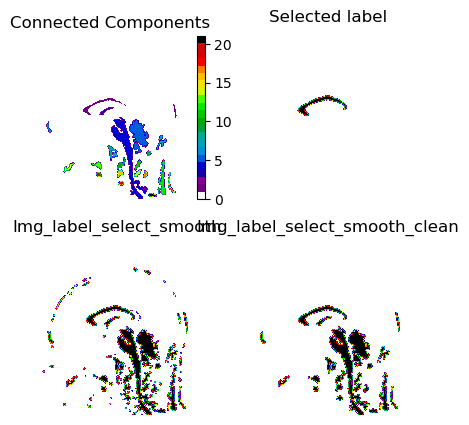

In [10]:
Img_label_select_filter = gaussian(Img_label_select, 2, 
                            preserve_range=True)
Img_label_select_smooth = Img_label_select_filter>0.25
Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth, min_size=150,connectivity=1),
    area_threshold=150)

# Extract connected components
Thresh = Img_label_select_smooth_clean
output = cv2.connectedComponentsWithStats(Thresh.astype(np.uint8))
(numLabels, labels, stats, centroids) = output
print('Max value in labels = ',labels.max())
print('Number of connected components = ',numLabels)

# Extract 1 connected component
thresh = labels==1

# plots results
Colormap = my_colormap_white_bkg('nipy_spectral',numLabels)
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()

tmp     = ax[0].imshow(labels, cmap=Colormap)
divider   = make_axes_locatable(ax[0])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[0].set_title('Connected Components')
ax[0].axis('off')
fig.colorbar(tmp, cax=cax, orientation='vertical')

ax[1].imshow(thresh, cmap=Colormap)
ax[1].set_title('Selected label')
ax[1].axis('off')
ax[2].imshow(Img_label_select_smooth, cmap=Colormap)
ax[2].set_title('Img_label_select_smooth')
ax[2].axis('off')
ax[3].imshow(Img_label_select_smooth_clean, cmap=Colormap)
ax[3].set_title('Img_label_select_smooth_clean');
ax[3].axis('off');




## Implement your full segmentation pipeline

### TO DO:
* Implement a full pipeline to segment TWO EXAMPLES from a single use case. Your code must run over the two cases in a loop. We need to be able to run the code without any adjustment to local path to access the input data. <br>
* Implement and compute a quality metric (eg Dice, overlap, relative area differences, errors between max diameters (something used to measure tumors), distances between contours) that compares your final segmentation with the ground-truth.
* Extra point if you provide results on more use-cases or more than 2 examples per use case. <br>
* Feel free to also test your segmentation pipeline on images degraded by noise for example. <br>
* Your final solution can involve registration or active contours from previous lectures. Just make sure to include the required functions and imports in your final notebook.<br>

### If you use the cardiac MRI dataset:
* Extra point because extra difficulties to load and prepare the data. <br>
* In this case the data preparation is part of your code below as you can only rely on the input data provided as it is.  <br>
* Use any slice from any case you want as your "learning" ground truths on which you can learn object size or shape characteristics for example. <br>
* Test your segmentation on any slice from any case, as long as the slices were not part of your "learning" ground-truth. <br>
* See if you can get your solution to not detect anything on slices that don't contain the left ventricle myocardium. <br>


### Important instructions:
* You cannot use the ground truth of the images you segment to segment them! But you can use the ground-truths of other examples of the same use-case to learn a priori knowledge such as size or average pixel intensity.<br>
* List all your hard-coded hyperparameters at the beginning of your code, indicating a variable name and its value. You will be penalised if you leave any hard-coded hyperparameter values inside your code. <br>

Nb: Dice = np.sum([seg==gt])*2.0/(np.sum(seg)+np.sum(gt)) #seg is the segmentation and gt is the ground truth. Both are of same size

Shape of mask: (512, 512)
Shape of mask: (256, 256)
Shape of mask: (320, 320)
Shape of mask: (512, 512)


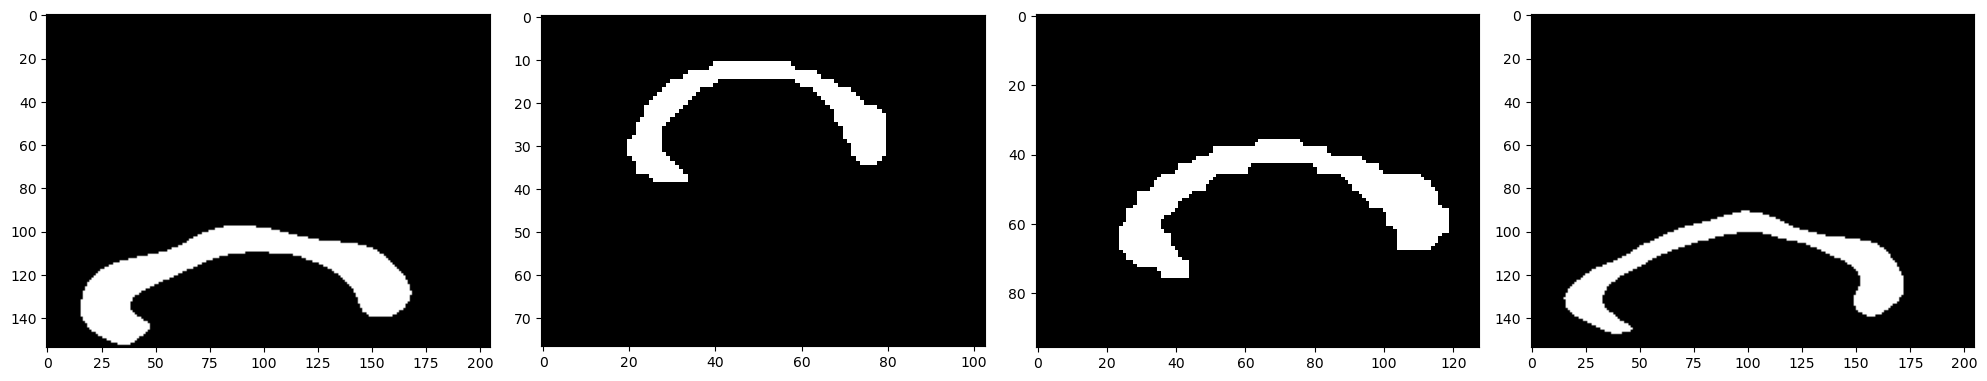

In [115]:
indexIm      = 1 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename) 

fig, axes        = plt.subplots(1,4, figsize=(20, 10))
ax               = axes.ravel()

for indexIm in range(4):
    filename_seg = listImagesbrainMRI[indexIm]
    Seg_brain_ex = imread(filename_seg)
    filename     = filename_seg[:-8] + '.png'
    Img_brain_ex = imread(filename)
    ax[indexIm].imshow(Seg_brain_ex[int(Seg_brain_ex.shape[1]*0.2):int(Seg_brain_ex.shape[1]*0.5),int(Seg_brain_ex.shape[1]*0.3):int(Seg_brain_ex.shape[1]*0.7)], cmap="gray")
    print(f"Shape of mask: {Seg_brain_ex.shape}")
    
fig.tight_layout()

In [274]:
import scipy
from skimage.exposure import match_histograms

In [69]:
## using IoU to evaluate the accuracy
def calculate_iou(mask1, mask2):
    # Ensure masks are boolean
    mask1 = mask1.astype(np.bool_)
    mask2 = mask2.astype(np.bool_)
    
    # Intersection and union
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    
    # Sum over the masks to count the True values (which are 1s)
    intersection_sum = np.sum(intersection)
    union_sum = np.sum(union)
    
    # Calculate IoU
    iou = intersection_sum / float(union_sum)
    
    return iou

In [233]:
def select_labelMRI(labels, cropped=False):
    if cropped==False:
        flat = labels[int(labels.shape[1]*0.2):int(labels.shape[1]*0.5),int(labels.shape[1]*0.3):int(labels.shape[1]*0.7)]
    else:
        flat = labels
    flat = flat.flatten()
    flat = flat[flat != 0]
    # Find the mode (most frequent value) in the filtered array
    mode_result = scipy.stats.mode(flat)
    # Extract the mode value
    my_label = mode_result[0]

        
    return my_label

## Preprocessing of the image
We try different correction seen in the TP for active contours


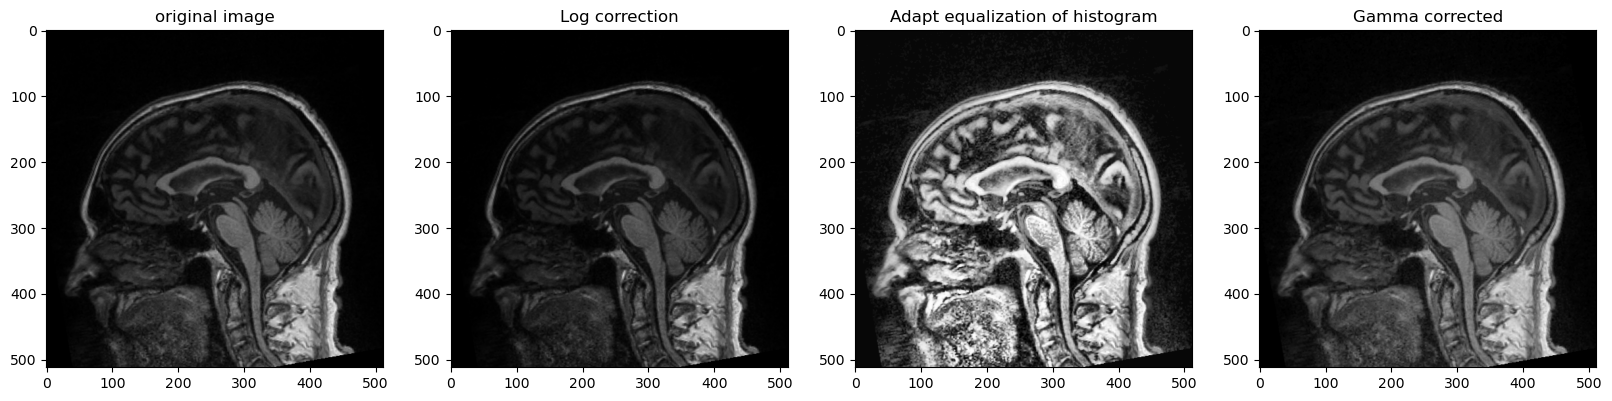

In [96]:
img_ori_to_test = Img_brain_ex
img_to_test = img_ori_to_test
logarithmic_corrected = skimage.exposure.adjust_log(img_to_test, gain= 1,inv=True)
img_adapteq           = skimage.exposure.equalize_adapthist(img_to_test, clip_limit=0.03)
gamma_corrected       = skimage.exposure.adjust_gamma(img_to_test, 0.8)

fig = plt.figure(figsize=(20,10))
fig.add_subplot(1,4,1)
plt.imshow(img_ori_to_test, cmap = "gray")
plt.title("original image")

fig.add_subplot(1,4,2)
plt.imshow(logarithmic_corrected, cmap = "gray")
plt.title("Log correction")

fig.add_subplot(1,4,3)
plt.imshow(img_adapteq, cmap = "gray")
plt.title("Adapt equalization of histogram")

fig.add_subplot(1,4,4)
plt.imshow(gamma_corrected, cmap = "gray")
plt.title("Gamma corrected")

plt.show()

## segmenting with log correction image

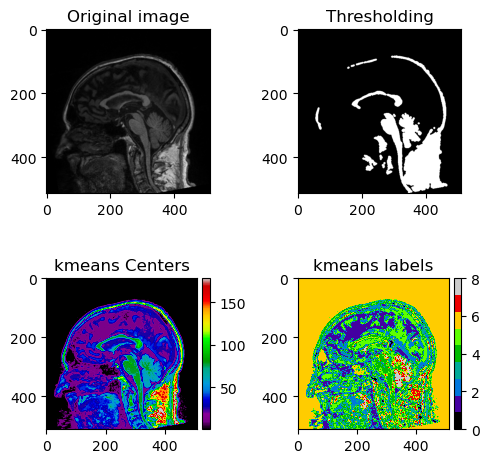

In [135]:
nber_clusters     = 9; Target_value_thresh = 50 # For brain image
Img_test          = logarithmic_corrected ; Img_seg_gt       = Seg_brain_ex

# [1] Example of segmentation via simple threshold 
# Compute a mask thresholding above target value
Seg_thresh          = morphology.remove_small_holes(
                        morphology.remove_small_objects(
                          Img_test > Target_value_thresh, 
                            min_size=500,connectivity=1),
                             area_threshold=500)
Seg_thresh = morphology.opening(Seg_thresh, morphology.disk(3))
Seg_thresh = Seg_thresh.astype('uint8')

# [2] Example of segmentation via kmeans 
Seg_km,Seg_km_labels = my_kmeans(Img_test,nber_clusters)
# get discrete colormap to display results
Colormap  = plt.get_cmap('nipy_spectral', nber_clusters)

# Display results
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()

ax[0].imshow(Img_test, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(Seg_thresh, cmap='gray')
ax[1].set_title('Thresholding')

tmp       = ax[2].imshow(Seg_km, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[2])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[2].set_title('kmeans Centers')
fig.colorbar(tmp, cax=cax, orientation='vertical')

tmp     = ax[3].imshow(Seg_km_labels, cmap=Colormap)
# tmp     = ax[3].imshow(Seg_km_labels, cmap='nipy_spectral')
divider = make_axes_locatable(ax[3])
cax     = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(tmp, cax=cax, orientation='vertical')
ax[3].set_title('kmeans labels')

fig.tight_layout()
plt.show();

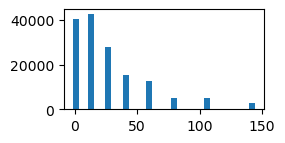

Your Target_value =  93
Distance of your Target_value to Centers =  [13 81 52 86 14 67 92 49 34]
Your selected label (starting with 0)=  0


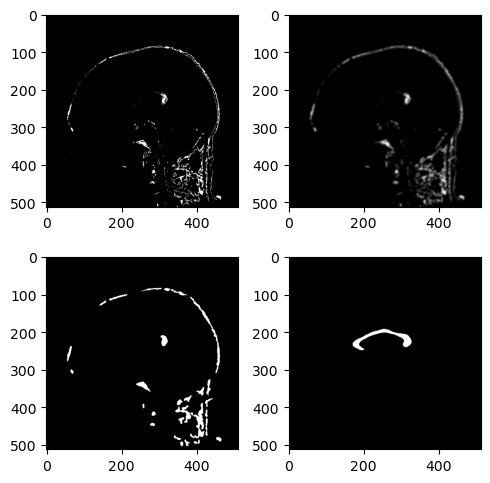

In [136]:
# Get mean pixel intensity values under all Kmeans labels
Img_label_means = np.empty(nber_clusters)
for i in range(0,nber_clusters):
    Img_label_mask = Seg_km_labels==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(Img_test, Img_label_mask)
    Img_label_means[i] = tmp[0]
#print(Img_label_means)

# Plot histograms of Kmeans clusters
Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
hist_kmeans, bins_kmeans  = np.histogram(Seg_km.flatten(), 
                                         bins=Bins)
bar_width = 5
fig       = plt.figure(figsize=(2, 1))
ax        = fig.add_axes([0,0,1,1])
ax.bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);
plt.show()

# Set a target intensity value and get the Kmeans label closest to it
Target_value = cv2.mean(Img_test, Seg_thresh)
Target_value = Target_value[0]
Diff = np.absolute(Img_label_means-Target_value*np.ones(nber_clusters))
Label_select = np.argmin(Diff)
print('Your Target_value = ', np.round(Target_value).astype(int))
print('Distance of your Target_value to Centers = ', np.round(Diff).astype(int))
print('Your selected label (starting with 0)= ', Label_select)



# Filter the selected label and get a binary segmentation mask
Img_label_select  = Seg_km_labels==Label_select
Img_label_select  = Img_label_select.astype('float64')


# Examples to refine your segmentation mask
Img_label_select_smooth = gaussian(Img_label_select, 2, 
                            preserve_range=True)

Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth>0.25, min_size=50,connectivity=1),
    area_threshold=50)


fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()
ax[0].imshow(Img_label_select, cmap='gray')
ax[1].imshow(Img_label_select_smooth, cmap='gray')
ax[2].imshow(Img_label_select_smooth_clean, cmap='gray')
ax[3].imshow(Img_seg_gt, cmap='gray')

fig.tight_layout()
plt.show()

We can say that log correction is not ideal for brain segmentation, if we put into kmeans

Note: but the result of direct thresholding with preprocessing is not bad



Max value in labels =  14
Number of connected components =  15


(-0.5, 511.5, 511.5, -0.5)

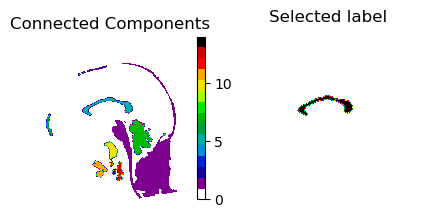

In [149]:
## directly using threshold result to do the connected components
# Extract connected components
Thresh = Seg_thresh
output = cv2.connectedComponentsWithStats(Thresh.astype(np.uint8))
(numLabels, labels, stats, centroids) = output
print('Max value in labels = ',labels.max())
print('Number of connected components = ',numLabels)

# Extract 1 connected component
# thresh = labels==5
thresh = labels == select_labelMRI(labels)

# plots results
Colormap = my_colormap_white_bkg('nipy_spectral',numLabels)
fig, axes = plt.subplots(1,2, figsize=(5, 5))
ax        = axes.ravel()

tmp     = ax[0].imshow(labels, cmap=Colormap)
divider   = make_axes_locatable(ax[0])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[0].set_title('Connected Components')
ax[0].axis('off')
fig.colorbar(tmp, cax=cax, orientation='vertical')

ax[1].imshow(thresh, cmap=Colormap)
ax[1].set_title('Selected label')
ax[1].axis('off')



In [104]:
calculate_iou(thresh, Img_seg_gt)

0.8911504424778761

Max value in labels =  38
Number of connected components =  39


(-0.5, 511.5, 511.5, -0.5)

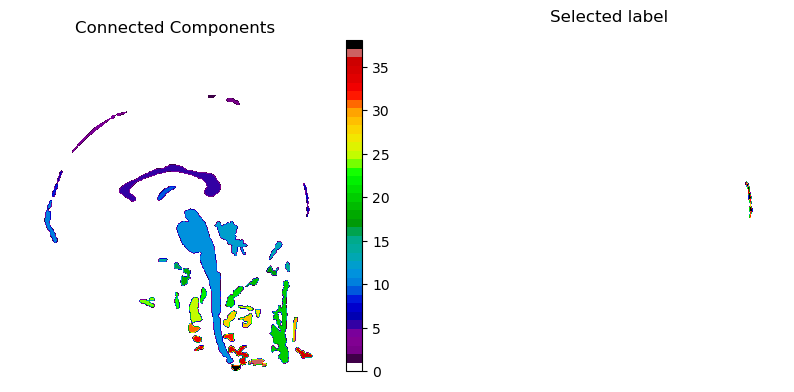

In [105]:
## using the k means result
Thresh = Img_label_select_smooth_clean
output = cv2.connectedComponentsWithStats(Thresh.astype(np.uint8))
(numLabels, labels, stats, centroids) = output
print('Max value in labels = ',labels.max())
print('Number of connected components = ',numLabels)

# Extract 1 connected component
thresh = labels==7

# plots results
Colormap = my_colormap_white_bkg('nipy_spectral',numLabels)
fig, axes = plt.subplots(1,2, figsize=(10, 5))
ax        = axes.ravel()

tmp     = ax[0].imshow(labels, cmap=Colormap)
divider   = make_axes_locatable(ax[0])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[0].set_title('Connected Components')
ax[0].axis('off')
fig.colorbar(tmp, cax=cax, orientation='vertical')

ax[1].imshow(thresh, cmap=Colormap)
ax[1].set_title('Selected label')
ax[1].axis('off')



In [86]:
calculate_iou(thresh, Img_seg_gt)

0.882858435097241

### packaging of segmentation using logarithm correction

In [270]:
# histogram matchin
def match_histograms(source, reference):
    # Calculate the histograms and their CDFs for both images
    source_hist, bins = np.histogram(source.flatten(), 256, [0,256])
    source_cdf = source_hist.cumsum()

    reference_hist, bins = np.histogram(reference.flatten(), 256, [0,256])
    reference_cdf = reference_hist.cumsum()

    # Normalize the CDFs
    source_cdf_normalized = source_cdf * reference_hist.max() / source_cdf.max()
    reference_cdf_normalized = reference_cdf * source_hist.max() / reference_cdf.max()

    # Create a lookup table to map pixel values
    lookup_table = np.zeros(256)
    for i in range(256):
        idx = np.abs(source_cdf_normalized[i] - reference_cdf_normalized).argmin()
        lookup_table[i] = idx

    # Apply the mapping to the source image
    result_image = cv2.LUT(source.astype('uint8'), lookup_table.astype('uint8'))

    return result_image

In [271]:
indexIm      = 3 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename) 
img_ref = Img_brain_ex

In [276]:
indexIm      = 2 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
img_to_match = imread(filename) 
img_matched = match_histograms(img_to_match, img_ref)

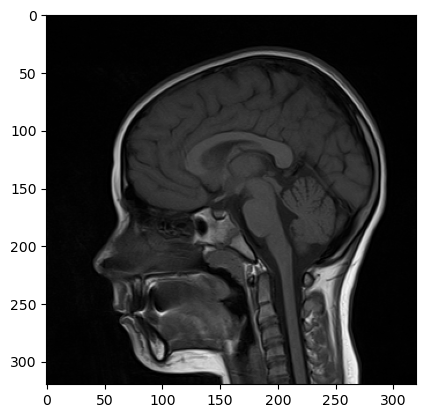

In [278]:
plt.imshow(img_to_match, cmap="gray")

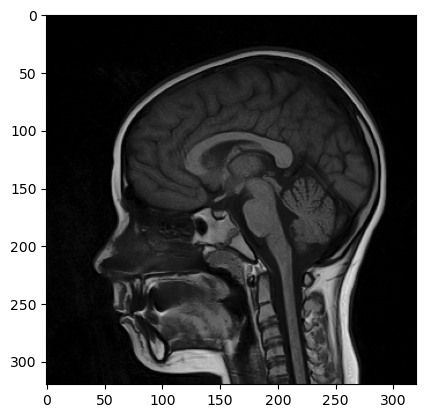

In [277]:
plt.imshow(img_matched, cmap="gray")

In [234]:
def crop_im(image, row_min=0.2, row_max=0.5, col_min=0.3, col_max=0.7):
    cropped_img = image[int(image.shape[0]*row_min):int(image.shape[0]*row_max), int(image.shape[1]*col_min):int(image.shape[1]*col_max)]
    return cropped_img

In [235]:
def scale_im(image):
    image = image.astype(np.float64)
    # Normalize the image
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    # Scale to [0, 255]
    scaled_image = normalized_image * 255
    # Convert back to an unsigned 8-bit integer type
    final_image = scaled_image.astype(np.uint8)
    return final_image

In [315]:
def log_correct_segMRI(img_ori, Target_value_thresh = 50):
#     img_ori = crop_im(img_ori)
    img_ori = match_histograms(img_ori, img_ref)
    img_ori = scale_im(img_ori)
    print(f"min: {img_ori.min()}, max: {img_ori.max()}, avg: {img_ori.mean()}")
    # correct the image using logarithm correction
    logarithmic_corrected = skimage.exposure.adjust_log(img_ori, gain= 1,inv=True)
    Img_test          = logarithmic_corrected
    
    # thresholding
    Seg_thresh          = morphology.remove_small_holes(
                        morphology.remove_small_objects(
                          Img_test > Target_value_thresh, 
                            min_size=500,connectivity=1),
                             area_threshold=500)
    Seg_thresh = morphology.opening(Seg_thresh, morphology.disk(1))
    Seg_thresh = Seg_thresh.astype('uint8')
    
    fig, axes = plt.subplots(1,2, figsize=(10, 5))
    ax        = axes.ravel()

    ax[0].imshow(Img_test, cmap='gray')
    ax[0].set_title('Original image')
    ax[1].imshow(Seg_thresh, cmap='gray')
    ax[1].set_title('Thresholding')

    
    ## directly using threshold result to do the connected components
    # Extract connected components
    Thresh = Seg_thresh
    output = cv2.connectedComponentsWithStats(Thresh.astype(np.uint8))
    (numLabels, labels, stats, centroids) = output
    print('Max value in labels = ',labels.max())
    print('Number of connected components = ',numLabels)

    # Extract 1 connected component
    # thresh = labels==5
    thresh = labels == select_labelMRI(labels, cropped=False)

    # plots results
    Colormap = my_colormap_white_bkg('nipy_spectral',numLabels)
    fig, axes = plt.subplots(1,2, figsize=(10, 5))
    ax        = axes.ravel()

    tmp     = ax[0].imshow(labels, cmap=Colormap)
    divider   = make_axes_locatable(ax[0])
    cax       = divider.append_axes('right', size='5%', pad=0.05)
    ax[0].set_title('Connected Components')
    ax[0].axis('off')
    fig.colorbar(tmp, cax=cax, orientation='vertical')

    ax[1].imshow(thresh, cmap=Colormap)
    ax[1].set_title('Selected label')
    ax[1].axis('off')
    
    return thresh
    

min: 0, max: 255, avg: 19.055618286132812
Max value in labels =  11
Number of connected components =  12


0.5826195947357427

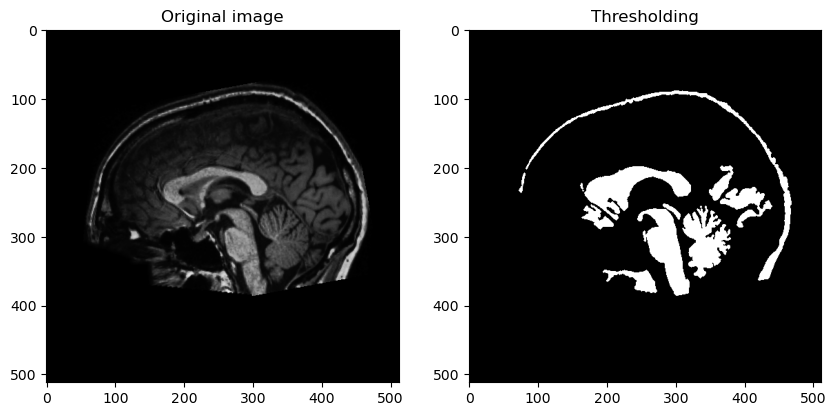

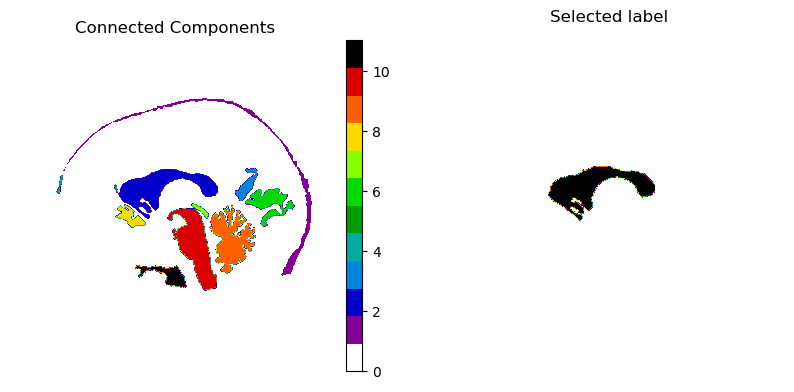

In [320]:
indexIm      = 0 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename)
thresh = log_correct_segMRI(Img_brain_ex, Target_value_thresh = 50)
calculate_iou(thresh, Seg_brain_ex)

min: 0, max: 255, avg: 32.55694580078125
Max value in labels =  20
Number of connected components =  21


0.35395458104933436

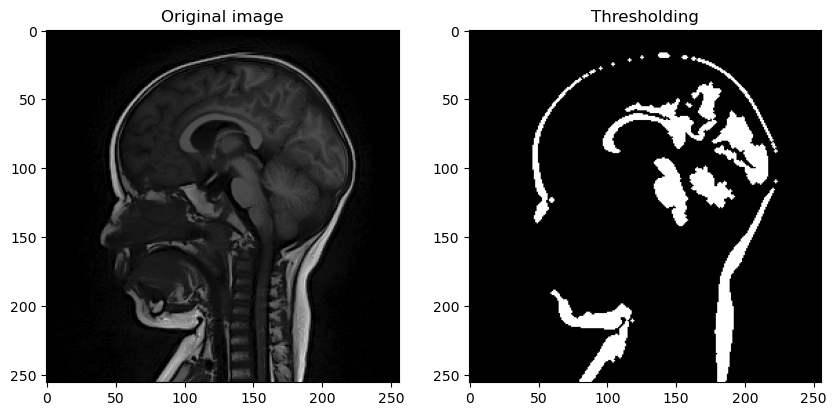

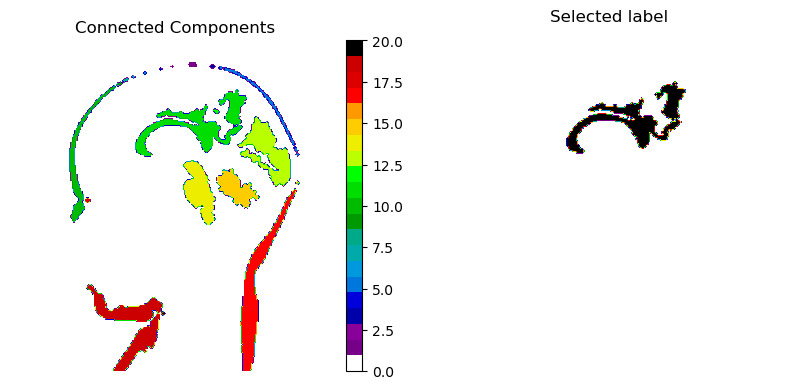

In [321]:
indexIm      = 1 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename)
thresh = log_correct_segMRI(Img_brain_ex, Target_value_thresh = 50)
calculate_iou(thresh, Seg_brain_ex)

min: 0, max: 255, avg: 32.278564453125
Max value in labels =  9
Number of connected components =  10


0.7951612903225806

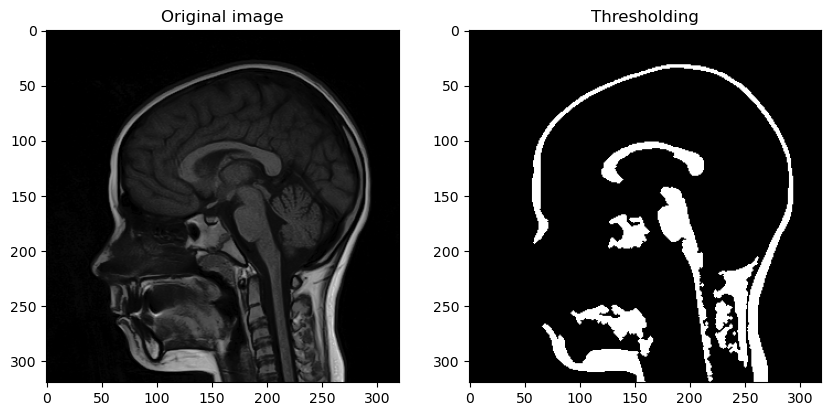

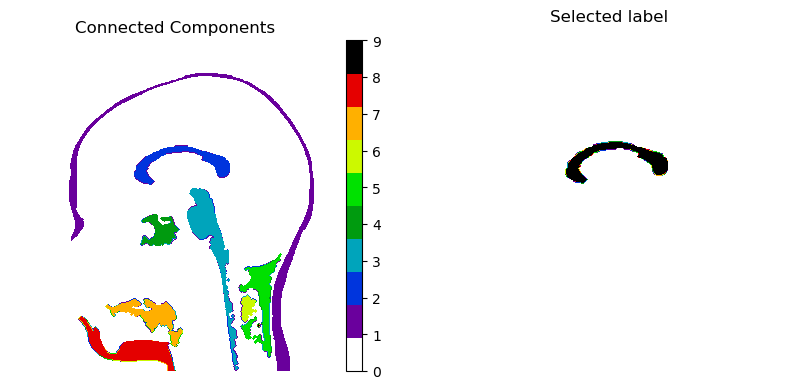

In [322]:
indexIm      = 2 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename)
thresh = log_correct_segMRI(Img_brain_ex, Target_value_thresh = 50)
calculate_iou(thresh, Seg_brain_ex)

min: 0, max: 255, avg: 33.05573654174805
Max value in labels =  9
Number of connected components =  10


0.8841463414634146

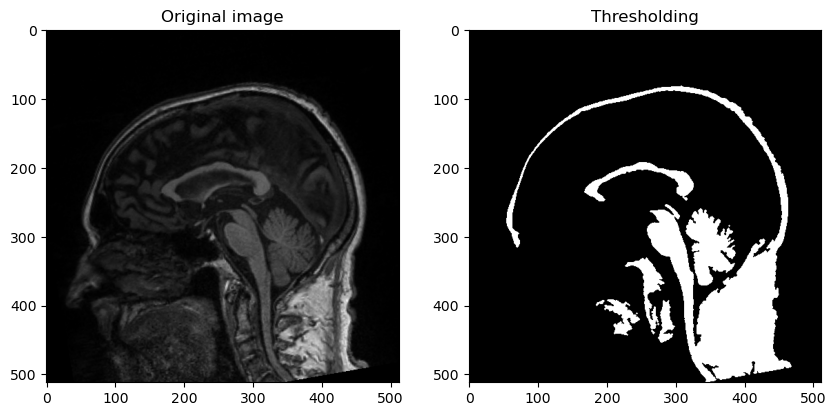

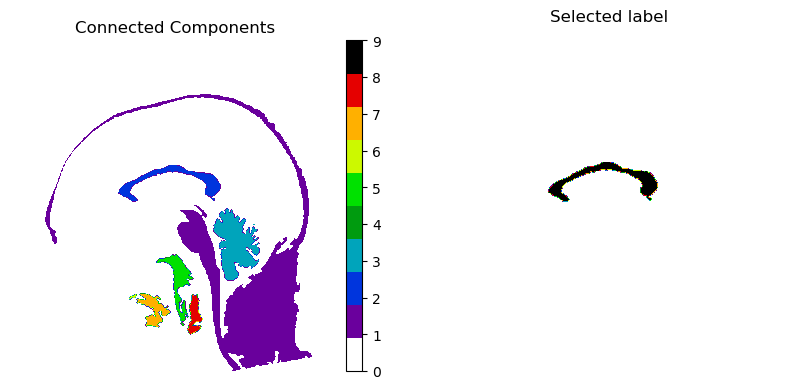

In [323]:
indexIm      = 3 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename)
thresh = log_correct_segMRI(Img_brain_ex, Target_value_thresh = 50)
calculate_iou(thresh, Seg_brain_ex)

## Segmentation with histogram equalization

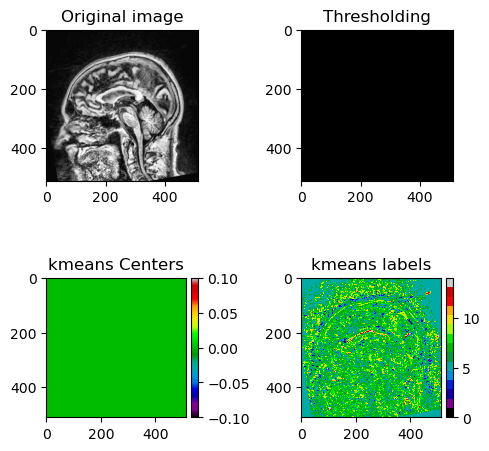

In [89]:
nber_clusters     = 15; Target_value_thresh = 1 # For brain image
Img_test          = img_adapteq ; Img_seg_gt       = Seg_brain_ex

# [1] Example of segmentation via simple threshold 
# Compute a mask thresholding above target value
Seg_thresh          = morphology.remove_small_holes(
                        morphology.remove_small_objects(
                          Img_test > Target_value_thresh, 
                            min_size=500,connectivity=1),
                             area_threshold=500)
Seg_thresh = morphology.opening(Seg_thresh, morphology.disk(3))
Seg_thresh = Seg_thresh.astype('uint8')

# [2] Example of segmentation via kmeans 
Seg_km,Seg_km_labels = my_kmeans(Img_test,nber_clusters)
# get discrete colormap to display results
Colormap  = plt.get_cmap('nipy_spectral', nber_clusters)

# Display results
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()

ax[0].imshow(Img_test, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(Seg_thresh, cmap='gray')
ax[1].set_title('Thresholding')

tmp       = ax[2].imshow(Seg_km, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[2])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[2].set_title('kmeans Centers')
fig.colorbar(tmp, cax=cax, orientation='vertical')

tmp     = ax[3].imshow(Seg_km_labels, cmap=Colormap)
# tmp     = ax[3].imshow(Seg_km_labels, cmap='nipy_spectral')
divider = make_axes_locatable(ax[3])
cax     = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(tmp, cax=cax, orientation='vertical')
ax[3].set_title('kmeans labels')

fig.tight_layout()
plt.show();



We can see that equalization is not that ideal

## Segmengtation with gamma correction

min: 0, max: 255, avg: 25.448001861572266


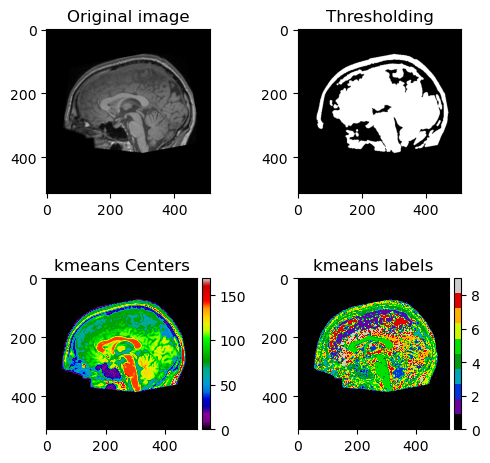

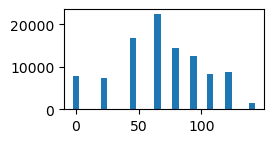

Your Target_value =  100
Distance of your Target_value to Centers =  [100  21  21  55  78  40  69   7  35   6]
Your selected label (starting with 0)=  9


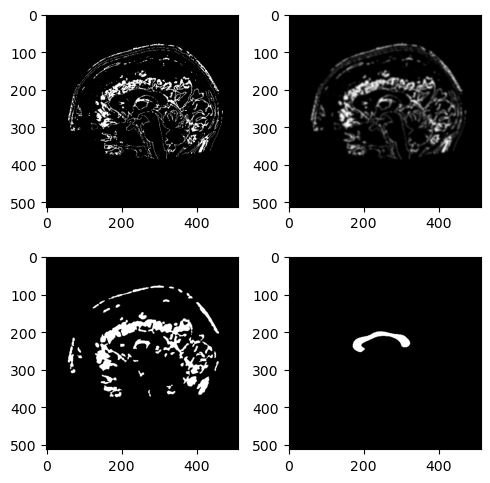

Max value in labels =  51
Number of connected components =  52


0.001604492579221821

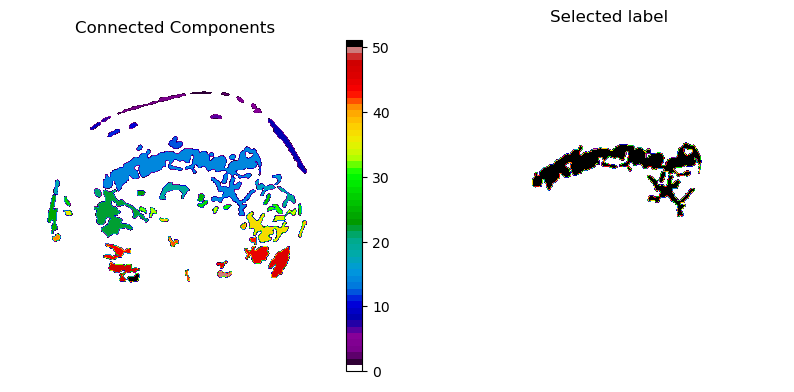

In [408]:
indexIm      = 0 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename)
thresh = gamma_correct_segMRI(Img_brain_ex, Target_value_thresh = 70)
calculate_iou(thresh, Seg_brain_ex)

min: 0, max: 255, avg: 33.05573654174805


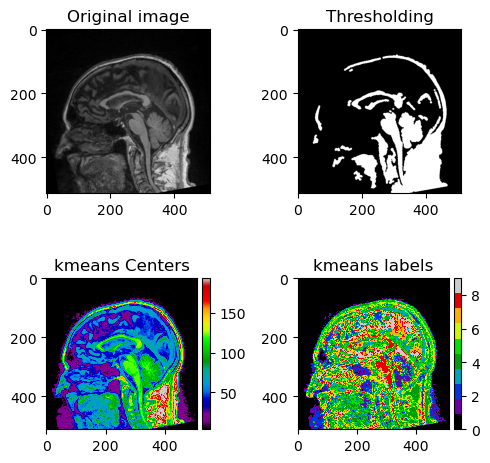

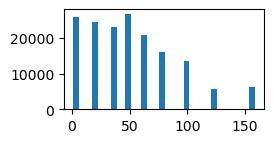

Your Target_value =  117
Distance of your Target_value to Centers =  [114  18  97  55  77  40  39  68   6  81]
Your selected label (starting with 0)=  9


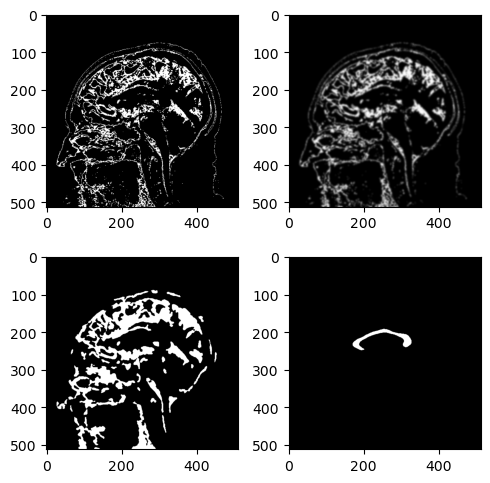

Max value in labels =  42
Number of connected components =  43


0.00011317978609020429

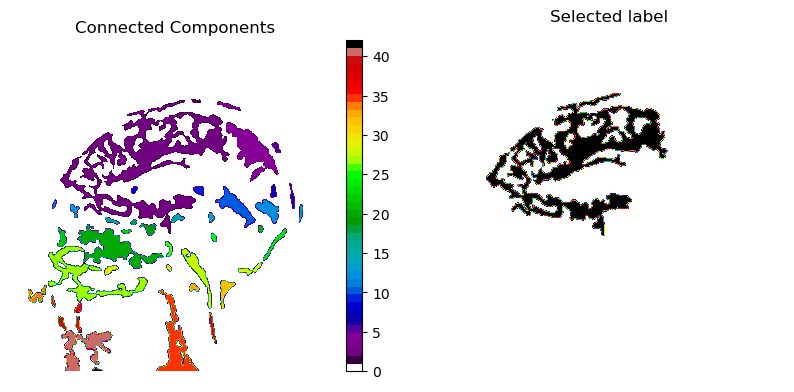

In [425]:
indexIm      = 3 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename)
thresh = gamma_correct_segMRI(Img_brain_ex, Target_value_thresh = 70)
calculate_iou(thresh, Seg_brain_ex)

min: 0, max: 255, avg: 33.192646484375


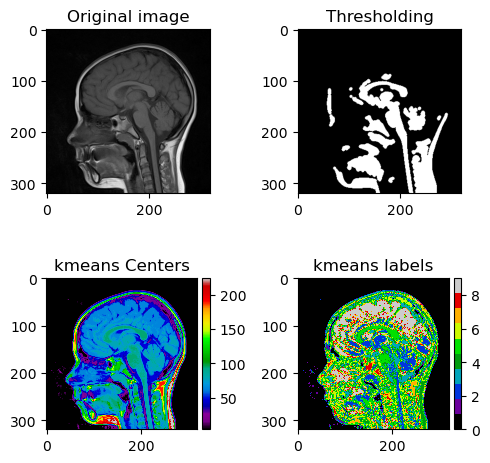

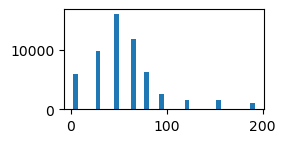

Your Target_value =  108
Distance of your Target_value to Centers =  [104  46  30  61 117  14  80  81  13  43]
Your selected label (starting with 0)=  9


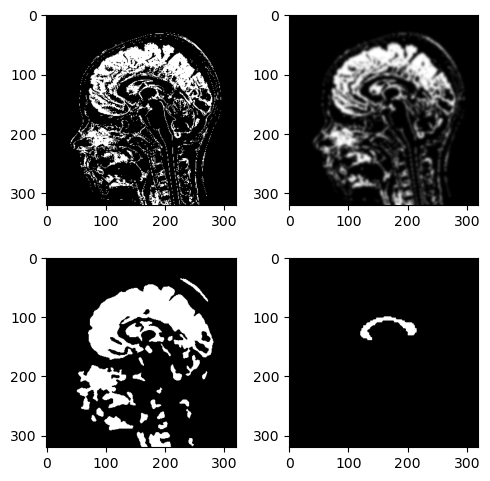

Max value in labels =  25
Number of connected components =  26


0.009574321531891444

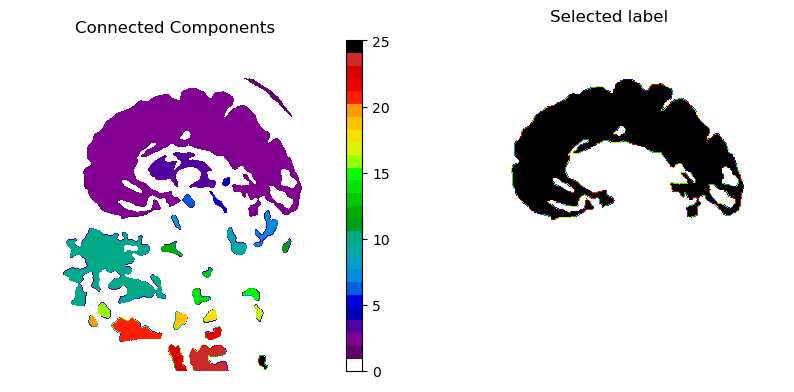

In [429]:
indexIm      = 2 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename)
thresh = gamma_correct_segMRI(Img_brain_ex, Target_value_thresh = 70)
calculate_iou(thresh, Seg_brain_ex)

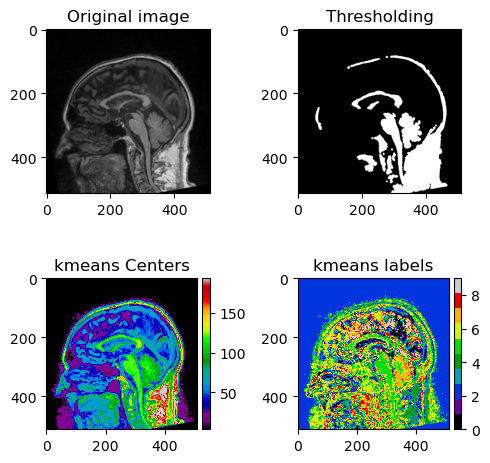

In [427]:
img_to_test = Img_brain_ex
gamma_corrected       = skimage.exposure.adjust_gamma(img_to_test, 0.8)
nber_clusters     = 10; Target_value_thresh = 80 # For brain image
Img_test          = gamma_corrected ; Img_seg_gt       = Seg_brain_ex

# [1] Example of segmentation via simple threshold 
# Compute a mask thresholding above target value
Seg_thresh          = morphology.remove_small_holes(
                        morphology.remove_small_objects(
                          Img_test > Target_value_thresh, 
                            min_size=500,connectivity=1),
                             area_threshold=500)
Seg_thresh = morphology.opening(Seg_thresh, morphology.disk(3))
Seg_thresh = Seg_thresh.astype('uint8')

# [2] Example of segmentation via kmeans 
Seg_km,Seg_km_labels = my_kmeans(Img_test,nber_clusters)
# get discrete colormap to display results
Colormap  = plt.get_cmap('nipy_spectral', nber_clusters)

# Display results
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()

ax[0].imshow(Img_test, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(Seg_thresh, cmap='gray')
ax[1].set_title('Thresholding')

tmp       = ax[2].imshow(Seg_km, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[2])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[2].set_title('kmeans Centers')
fig.colorbar(tmp, cax=cax, orientation='vertical')

tmp     = ax[3].imshow(Seg_km_labels, cmap=Colormap)
# tmp     = ax[3].imshow(Seg_km_labels, cmap='nipy_spectral')
divider = make_axes_locatable(ax[3])
cax     = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(tmp, cax=cax, orientation='vertical')
ax[3].set_title('kmeans labels')

fig.tight_layout()
plt.show();



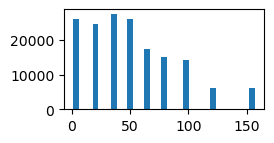

Your Target_value =  127
Distance of your Target_value to Centers =  [ 77  28 123  62  68   5 106  28  47  90]
Your selected label (starting with 0)=  5


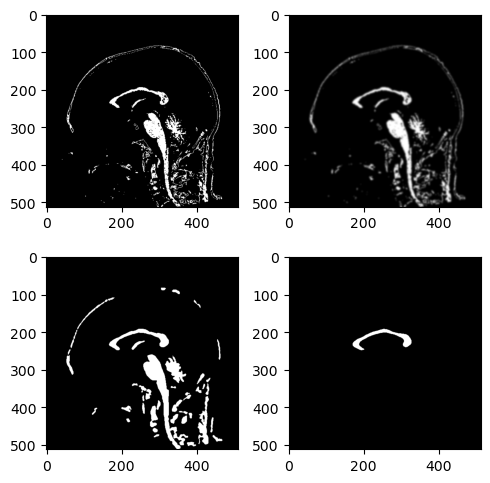

In [428]:
# Get mean pixel intensity values under all Kmeans labels
Img_label_means = np.empty(nber_clusters)
for i in range(0,nber_clusters):
    Img_label_mask = Seg_km_labels==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(Img_test, Img_label_mask)
    Img_label_means[i] = tmp[0]
#print(Img_label_means)

# Plot histograms of Kmeans clusters
Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
hist_kmeans, bins_kmeans  = np.histogram(Seg_km.flatten(), 
                                         bins=Bins)
bar_width = 5
fig       = plt.figure(figsize=(2, 1))
ax        = fig.add_axes([0,0,1,1])
ax.bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);
plt.show()

# Set a target intensity value and get the Kmeans label closest to it
Target_value = cv2.mean(Img_test, Seg_thresh)
Target_value = Target_value[0]
Diff = np.absolute(Img_label_means-Target_value*np.ones(nber_clusters))
Label_select = np.argmin(Diff)
# Label_select = select_labelMRI(Seg_km_labels)
print('Your Target_value = ', np.round(Target_value).astype(int))
print('Distance of your Target_value to Centers = ', np.round(Diff).astype(int))
print('Your selected label (starting with 0)= ', Label_select)



# Filter the selected label and get a binary segmentation mask
Img_label_select  = Seg_km_labels==Label_select
# Img_label_select = select_labelMRI(Seg_km_labels)
Img_label_select  = Img_label_select.astype('float64')


# Examples to refine your segmentation mask
Img_label_select_smooth = gaussian(Img_label_select, 2, 
                            preserve_range=True)

Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth>0.25, min_size=50,connectivity=1),
    area_threshold=50)


fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()
ax[0].imshow(Img_label_select, cmap='gray')
ax[1].imshow(Img_label_select_smooth, cmap='gray')
ax[2].imshow(Img_label_select_smooth_clean, cmap='gray')
ax[3].imshow(Img_seg_gt, cmap='gray')

fig.tight_layout()
plt.show()

It keeps the target part in one connected parts. So we continue to use it

Max value in labels =  34
Number of connected components =  35


(-0.5, 511.5, 511.5, -0.5)

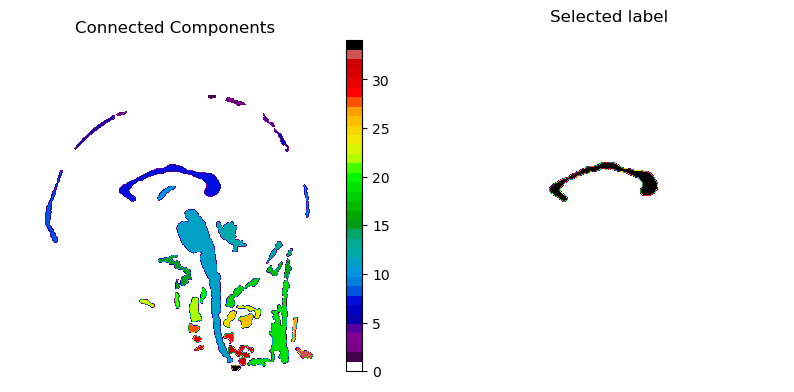

In [377]:
# Extract connected components
Thresh = Img_label_select_smooth_clean
output = cv2.connectedComponentsWithStats(Thresh.astype(np.uint8))
(numLabels, labels, stats, centroids) = output
print('Max value in labels = ',labels.max())
print('Number of connected components = ',numLabels)

# Extract 1 connected component
thresh = labels == select_labelMRI(labels)

# plots results
Colormap = my_colormap_white_bkg('nipy_spectral',numLabels)
fig, axes = plt.subplots(1,2, figsize=(10, 5))
ax        = axes.ravel()

tmp     = ax[0].imshow(labels, cmap=Colormap)
divider   = make_axes_locatable(ax[0])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[0].set_title('Connected Components')
ax[0].axis('off')
fig.colorbar(tmp, cax=cax, orientation='vertical')

ax[1].imshow(thresh, cmap=Colormap)
ax[1].set_title('Selected label')
ax[1].axis('off')



In [383]:
Img_seg_gt       = Seg_brain_ex
calculate_iou(thresh, Img_seg_gt)

0.0

### Packaging of segmentation with gamma correction

min: 0, max: 255, avg: 33.192646484375


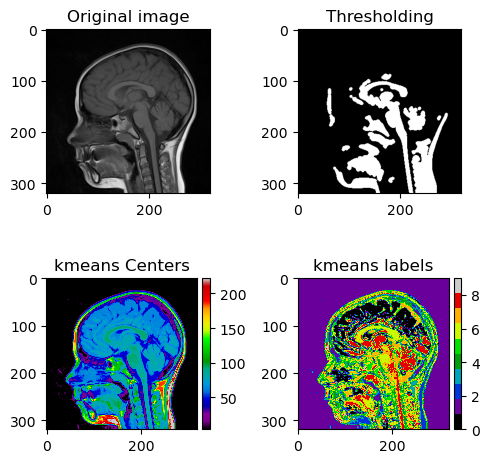

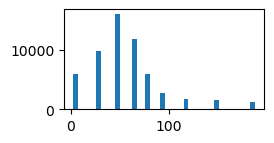

Your Target_value =  108
Distance of your Target_value to Centers =  [ 43 104 114  77  80   9  14  61  30  40]
Your selected label (starting with 0)=  8


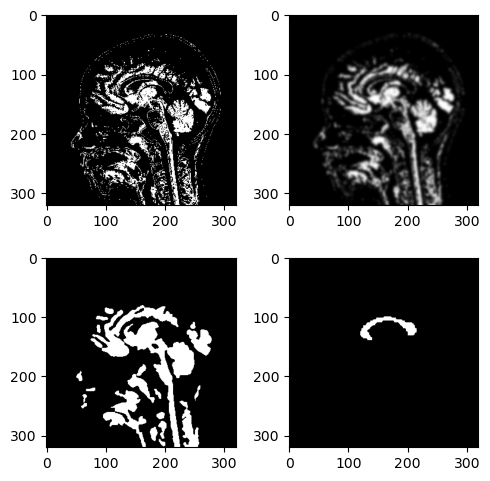

Max value in labels =  19
Number of connected components =  20


0.017792232638224603

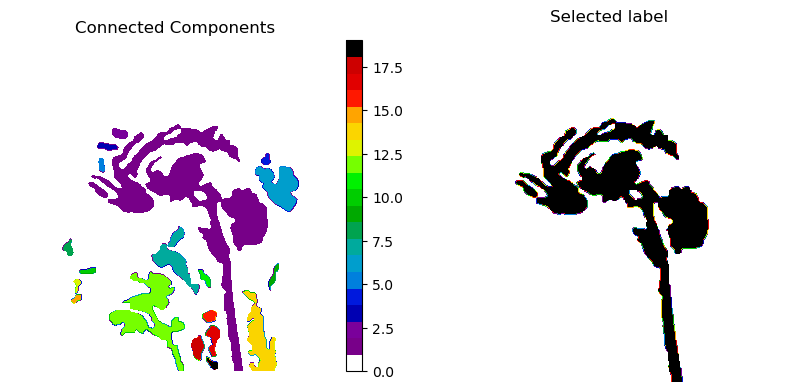

In [424]:
def gamma_correct_segMRI(img_ori, nber_clusters = 10, Target_value_thresh = 80):
#     img_ori = match_histograms(img_ori, img_ref2)
    img_ori = scale_im(img_ori)
    print(f"min: {img_ori.min()}, max: {img_ori.max()}, avg: {img_ori.mean()}")
    
    gamma_corrected       = skimage.exposure.adjust_gamma(img_ori, 0.8)
    Img_test          = gamma_corrected ; Img_seg_gt       = Seg_brain_ex

    # [1] Example of segmentation via simple threshold 
    # Compute a mask thresholding above target value
    Seg_thresh          = morphology.remove_small_holes(
                            morphology.remove_small_objects(
                              Img_test > Target_value_thresh, 
                                min_size=500,connectivity=1),
                                 area_threshold=500)
    Seg_thresh = morphology.opening(Seg_thresh, morphology.disk(3))
    Seg_thresh = Seg_thresh.astype('uint8')

    # [2] Example of segmentation via kmeans 
    Seg_km,Seg_km_labels = my_kmeans(Img_test,nber_clusters)
    # get discrete colormap to display results
    Colormap  = plt.get_cmap('nipy_spectral', nber_clusters)

    # Display results
    fig, axes = plt.subplots(2,2, figsize=(5, 5))
    ax        = axes.ravel()

    ax[0].imshow(Img_test, cmap='gray')
    ax[0].set_title('Original image')
    ax[1].imshow(Seg_thresh, cmap='gray')
    ax[1].set_title('Thresholding')

    tmp       = ax[2].imshow(Seg_km, cmap='nipy_spectral')
    divider   = make_axes_locatable(ax[2])
    cax       = divider.append_axes('right', size='5%', pad=0.05)
    ax[2].set_title('kmeans Centers')
    fig.colorbar(tmp, cax=cax, orientation='vertical')

    tmp     = ax[3].imshow(Seg_km_labels, cmap=Colormap)
    # tmp     = ax[3].imshow(Seg_km_labels, cmap='nipy_spectral')
    divider = make_axes_locatable(ax[3])
    cax     = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(tmp, cax=cax, orientation='vertical')
    ax[3].set_title('kmeans labels')

    fig.tight_layout()
    plt.show();
    
    
    # Get mean pixel intensity values under all Kmeans labels
    Img_label_means = np.empty(nber_clusters)
    for i in range(0,nber_clusters):
        Img_label_mask = Seg_km_labels==i
        Img_label_mask = Img_label_mask.astype('uint8')
        tmp            = cv2.mean(Img_test, Img_label_mask)
        Img_label_means[i] = tmp[0]
    #print(Img_label_means)

    # Plot histograms of Kmeans clusters
    Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
    hist_kmeans, bins_kmeans  = np.histogram(Seg_km.flatten(), 
                                             bins=Bins)
    bar_width = 5
    fig       = plt.figure(figsize=(2, 1))
    ax        = fig.add_axes([0,0,1,1])
    ax.bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);
    plt.show()

    # Set a target intensity value and get the Kmeans label closest to it
    Target_value = cv2.mean(Img_test, Seg_thresh)
    Target_value = Target_value[0]
    Diff = np.absolute(Img_label_means-Target_value*np.ones(nber_clusters))
    Label_select = np.argmin(Diff)
    Label_select = select_labelMRI(Seg_km_labels)
    print('Your Target_value = ', np.round(Target_value).astype(int))
    print('Distance of your Target_value to Centers = ', np.round(Diff).astype(int))
    print('Your selected label (starting with 0)= ', Label_select)



    # Filter the selected label and get a binary segmentation mask
    Img_label_select  = Seg_km_labels==Label_select
    Img_label_select  = Img_label_select.astype('float64')


    # Examples to refine your segmentation mask
    Img_label_select_smooth = gaussian(Img_label_select, 2, 
                                preserve_range=True)

    Img_label_select_smooth_clean = morphology.remove_small_holes(
        morphology.remove_small_objects(
            Img_label_select_smooth>0.25, min_size=50,connectivity=1),
        area_threshold=50)


    fig, axes = plt.subplots(2,2, figsize=(5, 5))
    ax        = axes.ravel()
    ax[0].imshow(Img_label_select, cmap='gray')
    ax[1].imshow(Img_label_select_smooth, cmap='gray')
    ax[2].imshow(Img_label_select_smooth_clean, cmap='gray')
    ax[3].imshow(Img_seg_gt, cmap='gray')

    fig.tight_layout()
    plt.show()
    
    # Extract connected components
    Thresh = Img_label_select_smooth_clean
    output = cv2.connectedComponentsWithStats(Thresh.astype(np.uint8))
    (numLabels, labels, stats, centroids) = output
    print('Max value in labels = ',labels.max())
    print('Number of connected components = ',numLabels)

    # Extract 1 connected component
    thresh = labels == select_labelMRI(labels)
#     thresh = labels == 1

    # plots results
    Colormap = my_colormap_white_bkg('nipy_spectral',numLabels)
    fig, axes = plt.subplots(1,2, figsize=(10, 5))
    ax        = axes.ravel()

    tmp     = ax[0].imshow(labels, cmap=Colormap)
    divider   = make_axes_locatable(ax[0])
    cax       = divider.append_axes('right', size='5%', pad=0.05)
    ax[0].set_title('Connected Components')
    ax[0].axis('off')
    fig.colorbar(tmp, cax=cax, orientation='vertical')

    ax[1].imshow(thresh, cmap=Colormap)
    ax[1].set_title('Selected label')
    ax[1].axis('off')
    return thresh

indexIm      = 2 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename)
thresh = gamma_correct_segMRI(Img_brain_ex, Target_value_thresh = 70)
calculate_iou(thresh, Seg_brain_ex)

min: 0, max: 255, avg: 33.05573654174805


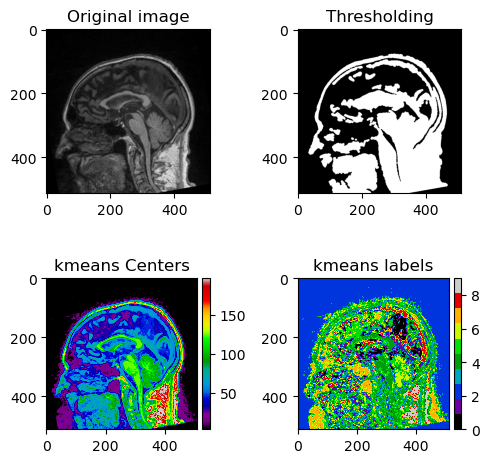

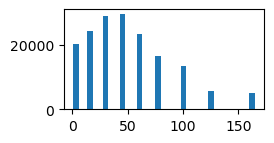

Your Target_value =  93
Distance of your Target_value to Centers =  [ 48  15  90  70  33  63   8  77  32 105]
Your selected label (starting with 0)=  6


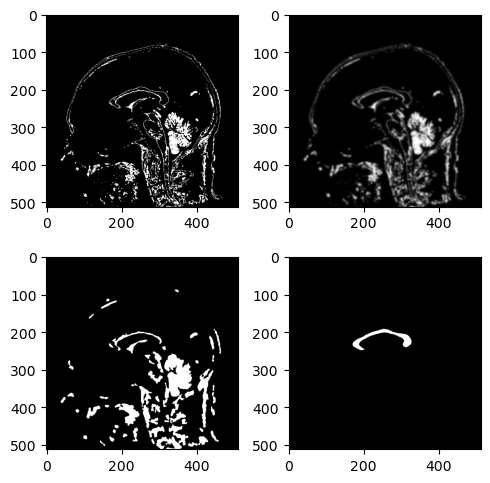

Max value in labels =  54
Number of connected components =  55


0.2651122625215889

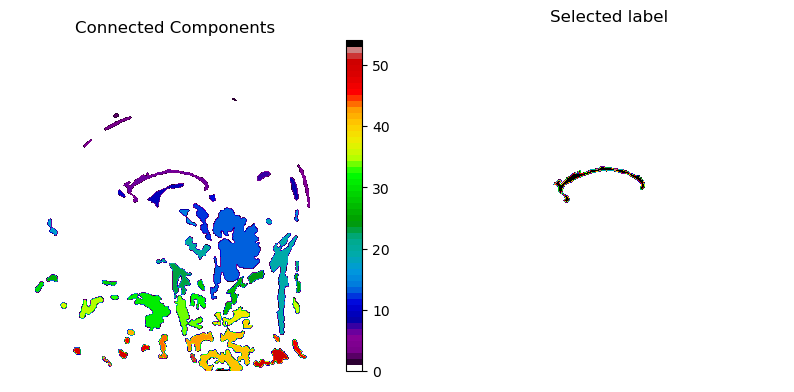

In [401]:
indexIm      = 3 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename)
thresh = gamma_correct_segMRI(Img_brain_ex, Target_value_thresh = 50)
calculate_iou(thresh, Seg_brain_ex)

# Draft

In [32]:
## first try thresholding
Target_value_thresh = 60
Seg_thresh          = morphology.remove_small_holes(
                        morphology.remove_small_objects(
                          Img_test > Target_value_thresh, 
                            min_size=500,connectivity=1),
                             area_threshold=500)
Seg_thresh = morphology.opening(Seg_thresh, morphology.disk(3))
Seg_thresh = Seg_thresh.astype('uint8')

Target_value = cv2.mean(Img_test, Seg_thresh)
Target_value = Target_value[0]

In [343]:
def normalize_to_unit8(image):
  # This function is used to conver a float image to an uint8 image
 
  mx = image.max()
  mn = image.min()

  image = ((image - mn)/(mx - mn)) * 255.0
  return np.round(image).astype(np.uint8)

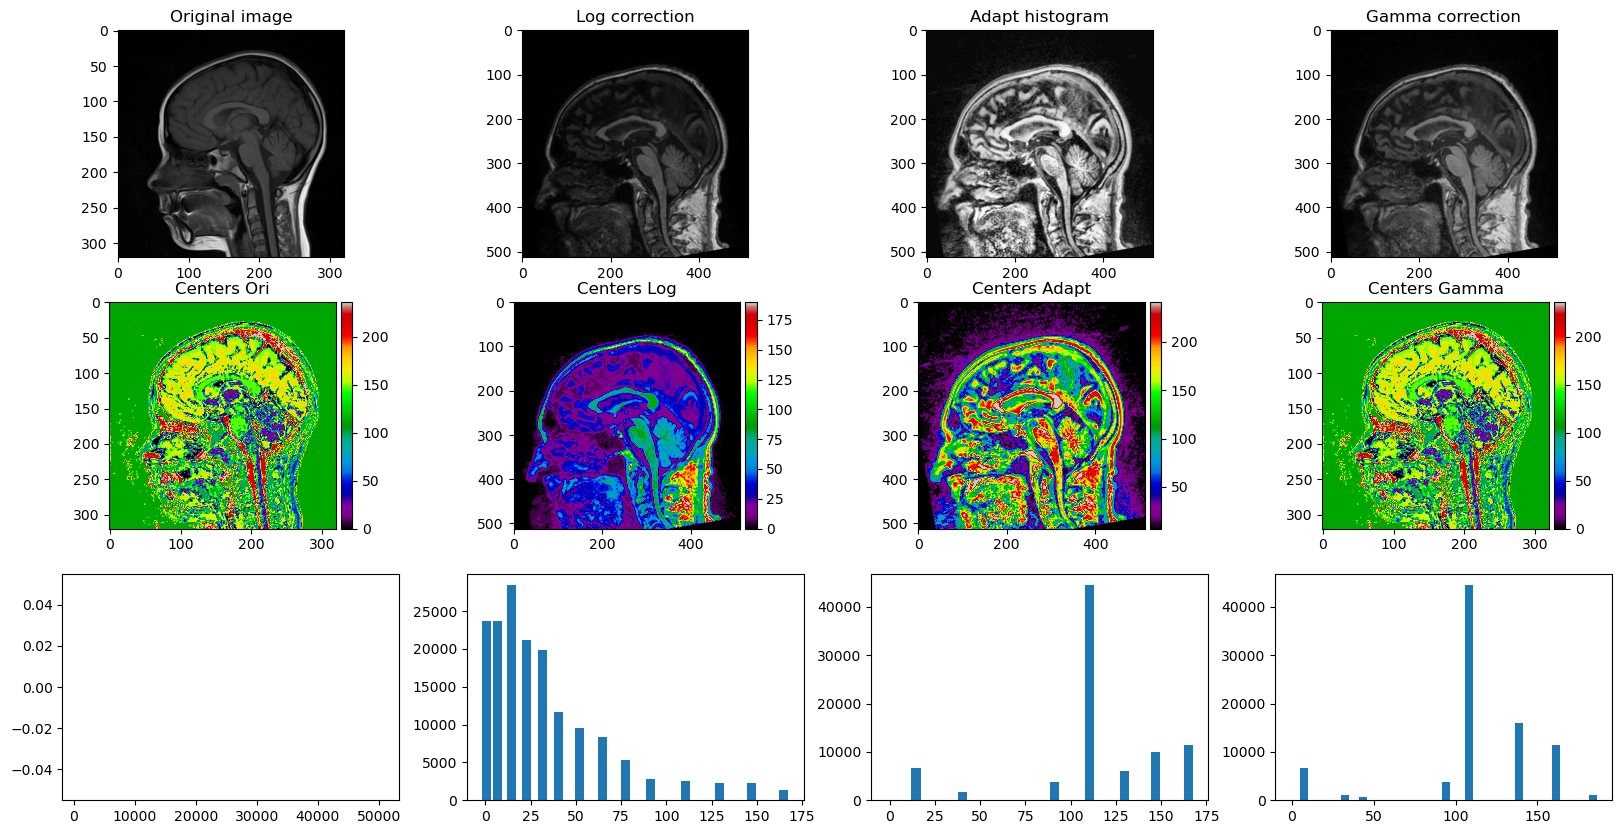

In [345]:
## kmeans segmentation with 4 images
img_test_ori = Img_brain_ex
img_test_log = logarithmic_corrected
img_test_adapteq = img_adapteq
img_test_adapteq = normalize_to_unit8(img_test_adapteq)
img_test_gamma = gamma_corrected

n_clusters = 15

seg_res_ori, seg_labels_ori = my_kmeans(img_test_ori, n_clusters)
seg_res_log, seg_labels_log = my_kmeans(img_test_log, n_clusters)
seg_res_adapteq, seg_labels_adapteq = my_kmeans(img_test_adapteq, n_clusters)
seg_res_gamma, seg_labels_gamma = my_kmeans(img_test_gamma, n_clusters)

Colormap  = plt.get_cmap('nipy_spectral', n_clusters)

fig,axes = plt.subplots(3,4,figsize=(20,10))
ax = axes.ravel()

ax[0].imshow(img_test_ori, cmap = 'gray')
ax[0].set_title('Original image')
tmp       = ax[4].imshow(seg_res_ori, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[4])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[4].set_title('Centers Ori')
fig.colorbar(tmp, cax=cax, orientation='vertical')
Img_label_means = np.empty(n_clusters)
for i in range(0,n_clusters):
    Img_label_mask = seg_labels_ori==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(img_test_ori, Img_label_mask)
    Img_label_means[i] = tmp[0]
# Plot histograms of Kmeans clusters
Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
hist_kmeans, bins_kmeans  = np.histogram(seg_res_ori.flatten(), 
                                         bins=Bins)
bar_width = 5
ax[8].bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);



ax[1].imshow(img_test_log, cmap = 'gray')
ax[1].set_title('Log correction')
tmp       = ax[5].imshow(seg_res_log, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[5])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[5].set_title('Centers Log')
fig.colorbar(tmp, cax=cax, orientation='vertical')
Img_label_means = np.empty(n_clusters)
for i in range(0,n_clusters):
    Img_label_mask = seg_labels_log==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(img_test_log, Img_label_mask)
    Img_label_means[i] = tmp[0]
# Plot histograms of Kmeans clusters
Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
hist_kmeans, bins_kmeans  = np.histogram(seg_res_log.flatten(), 
                                         bins=Bins)
bar_width = 5
ax[9].bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);

    
    
    
    
#### Show the 3rd column  
ax[2].imshow(img_test_adapteq, cmap = 'gray')
ax[2].set_title('Adapt histogram')
tmp       = ax[6].imshow(seg_res_adapteq, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[6])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[6].set_title('Centers Adapt')
fig.colorbar(tmp, cax=cax, orientation='vertical')
# Plot histograms of Kmeans clusters
Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
hist_kmeans, bins_kmeans  = np.histogram(seg_res_ori.flatten(), 
                                         bins=Bins)
bar_width = 5
ax[10].bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);



ax[3].imshow(img_test_gamma, cmap = 'gray')
ax[3].set_title('Gamma correction')
tmp       = ax[7].imshow(seg_res_ori, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[7])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[7].set_title('Centers Gamma')
fig.colorbar(tmp, cax=cax, orientation='vertical')
Img_label_means = np.empty(n_clusters)
for i in range(0,n_clusters):
    Img_label_mask = seg_labels_gamma==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(img_test_gamma, Img_label_mask)
    Img_label_means[i] = tmp[0]
# Plot histograms of Kmeans clusters
Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
hist_kmeans, bins_kmeans  = np.histogram(seg_res_ori.flatten(), 
                                         bins=Bins)
bar_width = 5
ax[11].bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);





# plot all the histogram of the image
# Img_label_means = np.empty(n_clusters)
# for i in range(0,nber_clusters):
#     Img_label_mask = Seg_km_labels==i
#     Img_label_mask = Img_label_mask.astype('uint8')
#     tmp            = cv2.mean(Img_test, Img_label_mask)
#     Img_label_means[i] = tmp[0]

plt.show()